# 1. Introduction

This workbook builds and evaluates an automatic classifier that assigns three labels to research papers: Discipline, Subfield, and Methodology. It culminates in a working inference tool that accepts PDFs and returns predicted labels with confidences.

How to use this notebook.
Run cells top-to-bottom. Sections are self-contained and save their outputs (metrics tables and figures) so later sections can load and compare results.

Evaluation focus. Macro-F1 is reported as the primary score because it reflects performance across all classes rather than being dominated by any single label. I also show per-class recall to make performance by category transparent.

What you will find here.

2. Data Loading & Preprocessing: Load data, apply light text cleaning, preview token lengths used later.

3. Baseline Models: Train TF-IDF baselines; write metrics CSVs for comparison.

4. Transformer Models: Single-label runs for SciBERT, RoBERTa, DistilBERT (“Model-1”), plus extended variants (C/D/E) with compact visualisations.

5. Model Comparisons: TF-IDF vs SciBERT, Model 1 comparisons, all models Macro-F1, and a unified per class recall heatmap.

6. Multi-Label Classification (SciBERT): One model predicting the three label types jointly.

7. Complete Classification Pipeline: Upload PDFs > extract abstract > return labels with confidences.

8. Conclusion & Discussion

Inference assets for Section 7: mlb.pkl, classes.npy, and the model checkpoint (e.g., multi_label_scibert.pt). The notebook will prompt if any are missing.

Environment. Runs on GPU; ran out of it so some with CPU. Random seeds are set where practical.

Outputs. All figures/tables displayed are also saved to disk for easy inclusion in the written report.

### Imports

In [ ]:
# install dependencies
!pip install -q transformers datasets scikit-learn pdfplumber

# general
import os
import io
import re
import time
import random
import string
import pickle
from dataclasses import dataclass
from typing import Dict, Any, List

# data and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from IPython.display import display

# nlp tools
import nltk
from nltk.corpus import stopwords
import spacy
import pdfplumber

# sklearn for ML
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, f1_score

# torch and transformers
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoModel
)

# huggingface
from datasets import Dataset

# 2. Data Loading & Preprocessing

Before training any models, the text is normalised into a consistent, model-friendly form. This section loads Ver5dataset_three_final.csv, removes rows without text_excerpt, and produces two canonical views of the text that the rest of the workbook will use.

The cleaning pipeline lowercases text, strips punctuation, runs spaCy lemmatisation, and optionally filters out stopwords (NLTK). From this, two columns are created:

processed_no_stopwords: suited to bag-of-words baselines such as TF-IDF.

processed_with_stopwords: keeps function words for transformer models that benefit from full sentence context (SciBERT/RoBERTa/DistilBERT) and for the final PDF-to-labels tool.

A short preview (head=5) of both processed columns is shown to verify the transformation, followed by printed counts for the three targets (discipline, subfield, methodology) to provide a quick sense of category coverage for the evaluations that follow.

Conventions used later: TF-IDF cells read processed_no_stopwords; all transformer experiments and the final inference pipeline read processed_with_stopwords.

In [ ]:
# Load data
from google.colab import files

# Upload dataset
uploaded = files.upload()

# Load the uploaded CSV file
df = pd.read_csv("Ver5dataset_three_final.csv")

# Drop rows with null in 'text_excerpt'
df = df[df['text_excerpt'].notnull()].copy()

Saving Ver5dataset_three_final.csv to Ver5dataset_three_final.csv


In [ ]:
# Text Processing
# Download NLTK stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocessing function
def preprocess_text(text, remove_stopwords=True):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_alpha:
            if remove_stopwords and token.text in stop_words:
                continue
            tokens.append(token.lemma_)
    return " ".join(tokens)

# Apply preprocessing
df['processed_no_stopwords'] = df['text_excerpt'].apply(lambda x: preprocess_text(str(x), remove_stopwords=True))
df['processed_with_stopwords'] = df['text_excerpt'].apply(lambda x: preprocess_text(str(x), remove_stopwords=False))

print("\nPreview of processed text (head=5):")
display(df[["processed_no_stopwords", "processed_with_stopwords"]].head(5))

# Show class counts
print("\nClass Distribution:")
print("Methodology:", df['methodology'].value_counts().to_dict())
print("Discipline:", df['discipline'].value_counts().to_dict())
print("Subfield:", df['subfield'].value_counts().to_dict())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Preview of processed text (head=5):


,processed_no_stopwords,processed_with_stopwords
0,report magnitude flash detect approximately mi...,we report on a magnitude flash detect for appr...
1,discuss feasibility gamma ray burst grb tev ga...,we discuss feasibility of gamma ray burst grb ...
2,dimension infiniterange kawasaki spin exchange...,in all dimension infiniterange kawasaki spin e...
3,technique develop explore complete space inter...,technique be develop for explore the complete ...
4,set general structure analysis frustrationfree...,we set up a general structure for the analysis...



Class Distribution:
Methodology: {'Design Science / System Design': 3601, 'Theoretical / Conceptual': 1477, 'Mixed Methods': 450, 'Qualitative': 54}
Discipline: {'Economics': 1263, 'Computer Science': 1259, 'Mathematics': 1101, 'Physics': 580, 'Statistics': 546, 'Quantitative Biology': 456, 'Astrophysics': 209, 'Electrical Engineering and Systems Science': 168}
Subfield: {'General Economics': 1714, 'Machine Learning': 1424, 'Algebraic Geometry': 1005, 'Neural and Cognitive Modeling': 486, 'Quantum Physics': 385, 'Computer Science and Game Theory': 273, 'Galaxy Astrophysics': 189, 'Image and Video Processing': 106}


# 3. Baseline Models (TF-IDF)

## 3.1 TF-IDF Basic

Section 3.1 trains baseline linear classifiers with a shared TF-IDF representation. The text is vectorised from processed_with_stopwords using TfidfVectorizer(max_features=3000), then split into train/test with a fixed seed (random_state=42) and stratification on the methodology label to keep the label mix comparable across splits.

Three models are fitted independently for: methodology, discipline, and subfield and an individual classification_report. In addition, the methodology run writes a single-row metrics file, tfidf_basic_methodology_metrics.csv, containing:

- run, val_acc, macro_f1
- per-class recalls for: Design Science / System Design, Mixed Methods, Qualitative, Theoretical / Conceptual

The results are:
- Methodology: overall accuracy is about 0.76; strong recall for Design Science/System Design and Mixed Methods, lower for Theoretical/Conceptual, and very limited performance on Qualitative. Macro-F1 is is about 0.39.
- Discipline: accuracy is about 0.48, with noticeable variation across classes (some high-recall categories and some lower-recall ones); macro-F1 is about 0.40.
- Subfield: accuracy is about 0.52; performance varies by category; macro-F1 is about 0.33.

In [ ]:
# Shared TF-IDF Vectorisation
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['processed_with_stopwords'])

# Shared Train/Test Split
X_train, X_test, idx_train, idx_test = train_test_split(
    X, df.index, test_size=0.2, random_state=42, stratify=df['methodology']
)

In [ ]:
def save_methodology_csv(run_name, y_true, y_pred, out_path):
    # build metrics
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    val_acc  = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    # pull recalls by class label
    recall_design = rep.get("Design Science / System Design", {}).get("recall", 0.0)
    recall_mixed  = rep.get("Mixed Methods", {}).get("recall", 0.0)
    recall_qual   = rep.get("Qualitative", {}).get("recall", 0.0)
    recall_tc     = rep.get("Theoretical / Conceptual", {}).get("recall", 0.0)

    # write CSV
    with open(out_path, mode="w", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            "run", "val_acc", "macro_f1",
            "recall_Design_Science_/_System_Design",
            "recall_Mixed_Methods",
            "recall_Qualitative",
            "recall_Theoretical_/_Conceptual"
        ])
        w.writerow([
            run_name, round(val_acc, 6), round(macro_f1, 6),
            round(recall_design, 6), round(recall_mixed, 6),
            round(recall_qual, 6), round(recall_tc, 6)
        ])
    print(f"Methodology metrics saved to {out_path}")

In [ ]:
# Methodology
y_m = df.loc[idx_train, 'methodology']
y_test_m = df.loc[idx_test, 'methodology']
model_m = LogisticRegression(max_iter=1000).fit(X_train, y_m)
y_pred_m = model_m.predict(X_test)
print("\n[Methodology - TFIDF Basic]")
print("Accuracy:", accuracy_score(y_test_m, y_pred_m))
print(classification_report(y_test_m, y_pred_m, zero_division=0))

# save CSV
save_methodology_csv(
    run_name="TFIDF_basic",
    y_true=y_test_m,
    y_pred=y_pred_m,
    out_path="tfidf_basic_methodology_metrics.csv"
)

# Discipline
y_d = df.loc[idx_train, 'discipline']
y_test_d = df.loc[idx_test, 'discipline']
model_d = LogisticRegression(max_iter=1000).fit(X_train, y_d)
y_pred_d = model_d.predict(X_test)
print("\n[Discipline - TFIDF Basic]")
print("Accuracy:", accuracy_score(y_test_d, y_pred_d))
print(classification_report(y_test_d, y_pred_d))

# Subfield
y_s = df.loc[idx_train, 'subfield']
y_test_s = df.loc[idx_test, 'subfield']
model_s = LogisticRegression(max_iter=1000).fit(X_train, y_s)
y_pred_s = model_s.predict(X_test)
print("\n[Subfield - TFIDF Basic]")
print("Accuracy:", accuracy_score(y_test_s, y_pred_s))
print(classification_report(y_test_s, y_pred_s))


[Methodology - TFIDF Basic]
Accuracy: 0.756490599820949
                                precision    recall  f1-score   support

Design Science / System Design       0.77      0.93      0.84       721
                 Mixed Methods       0.80      0.04      0.08        90
                   Qualitative       0.00      0.00      0.00        11
      Theoretical / Conceptual       0.72      0.57      0.63       295

                      accuracy                           0.76      1117
                     macro avg       0.57      0.39      0.39      1117
                  weighted avg       0.75      0.76      0.72      1117

Methodology metrics saved to tfidf_basic_methodology_metrics.csv

[Discipline - TFIDF Basic]
Accuracy: 0.4816472694717995
                                            precision    recall  f1-score   support

                              Astrophysics       0.86      0.61      0.71        41
                          Computer Science       0.27      0.34      0.30

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Subfield - TFIDF Basic]
Accuracy: 0.5201432408236347
                                  precision    recall  f1-score   support

              Algebraic Geometry       0.51      0.77      0.61       193
Computer Science and Game Theory       0.00      0.00      0.00        42
             Galaxy Astrophysics       0.75      0.50      0.60        36
               General Economics       0.63      0.65      0.64       370
      Image and Video Processing       0.00      0.00      0.00        18
                Machine Learning       0.40      0.55      0.46       275
   Neural and Cognitive Modeling       0.56      0.21      0.30       107
                 Quantum Physics       0.14      0.01      0.02        76

                        accuracy                           0.52      1117
                       macro avg       0.37      0.34      0.33      1117
                    weighted avg       0.48      0.52      0.48      1117



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.2 TF-IDF Kfold

Section 3.2 repeats the TF-IDF baselines with 5 fold stratified cross validation to check that the single split in 3.1 is representative. The same TF-IDF features are used. For each task:

- cross_val_score (scoring="accuracy") reports the mean CV accuracy.
- cross_val_predict yields out of fold predictions so a full classification_report can be printed on all items.
- The methodology run is also saved to tfidf_kfold_methodology_metrics.csv with the same fields as in 3.1 (run, val_acc, macro_f1, and per-class recalls).

The results are:

- Methodology: accuracy is about 0.76, macro-F1 is about 0.38. Pattern mirrors 3.1, strongest recall for Design Science / System Design and Mixed Methods; weaker for Theoretical / Conceptual and Qualitative.
- Discipline: accuracy is about 0.47, macro-F1 is about 0.39.
- Subfield: accuracy is about 0.52, macro-F1 is about 0.33.

Overall, K-Fold results are consistent with the single-split baseline, providing a stable reference for the transformer comparisons later in Section 5.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# methodology
print("\n[Methodology - TFIDF K-Fold]")
y_m = df['methodology']
model_m = LogisticRegression(max_iter=1000)
scores_m = cross_val_score(model_m, X, y_m, cv=cv, scoring='accuracy')
print("Cross-validated accuracy (mean):", np.mean(scores_m))
y_pred_m = cross_val_predict(model_m, X, y_m, cv=cv)
print(classification_report(y_m, y_pred_m, zero_division=0))

# save CSV
save_methodology_csv(
    run_name="TFIDF_kfold",
    y_true=y_m,
    y_pred=y_pred_m,
    out_path="tfidf_kfold_methodology_metrics.csv"
)

# discipline
print("\n[Discipline - TFIDF K-Fold]")
y_d = df['discipline']
model_d = LogisticRegression(max_iter=1000)
scores_d = cross_val_score(model_d, X, y_d, cv=cv, scoring='accuracy')
print("Cross-validated accuracy (mean):", np.mean(scores_d))
y_pred_d = cross_val_predict(model_d, X, y_d, cv=cv)
print(classification_report(y_d, y_pred_d))

# subfield
print("\n[Subfield - TFIDF K-Fold]")
y_s = df['subfield']
model_s = LogisticRegression(max_iter=1000)
scores_s = cross_val_score(model_s, X, y_s, cv=cv, scoring='accuracy')
print("Cross-validated accuracy (mean):", np.mean(scores_s))
y_pred_s = cross_val_predict(model_s, X, y_s, cv=cv)
print(classification_report(y_s, y_pred_s))


[Methodology - TFIDF K-Fold]
Cross-validated accuracy (mean): 0.7586887881325748
                                precision    recall  f1-score   support

Design Science / System Design       0.77      0.93      0.84      3601
                 Mixed Methods       0.80      0.02      0.03       450
                   Qualitative       0.00      0.00      0.00        54
      Theoretical / Conceptual       0.71      0.59      0.65      1477

                      accuracy                           0.76      5582
                     macro avg       0.57      0.39      0.38      5582
                  weighted avg       0.75      0.76      0.72      5582

Methodology metrics saved to tfidf_kfold_methodology_metrics.csv

[Discipline - TFIDF K-Fold]
Cross-validated accuracy (mean): 0.4704376482064413
                                            precision    recall  f1-score   support

                              Astrophysics       0.79      0.55      0.65       209
                        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.3 Baseline Model Comparisons

In section 3.3 I did a comparisons of the baseline between the TF-IDF models, and this is the observations:
- Validation accuracy: essentially identical, 0.756 (Basic) vs 0.759 (K-Fold).
- Macro-F1: similar, with the K-Fold mean slightly lower, 0.390 (Basic) vs 0.381 (K-Fold).

- Per-class recall:
  - Design Science / System Design: consistently high (at about 0.93 both).
  - Theoretical / Conceptual: comparable (at about 0.57 vs 0.59).
  - Mixed Methods: very low in both (at about 0.04 basic; 0.02 K-Fold).
  - Qualitative: 0.00 in both baselines.

The single-split and cross-validated baselines agree closely, so either can serve as the TF-IDF reference in later sections. The patterns also indicate which categories are well captured by bag-of-words features (e.g., DS/SD) and which will likely benefit from more expressive models, motivating the transformer experiments that follow.

In [ ]:
# Upload one or more CSVs
from google.colab import files
uploaded = files.upload()

# Read and stack them
dfs = [pd.read_csv(io.BytesIO(data)) for _, data in uploaded.items()]
table = pd.concat(dfs, ignore_index=True)

# Display + save
display(table)

Saving tfidf_basic_methodology_metrics.csv to tfidf_basic_methodology_metrics (1).csv
Saving tfidf_kfold_methodology_metrics.csv to tfidf_kfold_methodology_metrics (1).csv


,run,val_acc,macro_f1,recall_Design_Science_/_System_Design,recall_Mixed_Methods,recall_Qualitative,recall_Theoretical_/_Conceptual
0,TFIDF_basic,0.756491,0.390160,0.934813,0.044444,0.0,0.566102
1,TFIDF_kfold,0.758689,0.381373,0.931408,0.017778,0.0,0.591063


# 4. Transformer-Based Models

## 4.1 SciBERT Model 1

I set up SciBERT as a baseline transformer for methodology classification using only standard choices, an 80/20 split (seed=42), 512-token context to avoid truncation confounds, AdamW (2e-5) with small batches and gradient clipping, and a short 3-epoch run. Checkpoints were picked by validation accuracy for stability, while macro-F1 and per-class recall were logged for analysis and reuse in later plots.

On this minimal recipe the model reached val acc at about 0.82 and macro-F1 at about 0.59. Recall was very strong for Design Science / System Design ( at about 0.95) and Theoretical / Conceptual (at about 0.72), and lower for Mixed Methods (at about 0.35) and Qualitative (at about 0.17). That pattern suggests SciBERT already captures terminology-rich methodological cues, while categories whose signals are more diffuse across the abstract remain harder.

What this leads to next. Building directly on this baseline, I explore three focused SciBERT variants:

- C1 (baseline @ 256 tokens): halve the sequence length to check if a shorter window maintains performance while improving efficiency.

- C2 (loss weights): test simple class weighting to see if minority recalls rise monitoring for instability or overfitting side-effects.

- C3 (combo): combine the shorter context with light warm-up/reshuffling and weights to probe whether gains compound or trade off.

These controlled changes keep the core model fixed and vary one or two factors at a time, so any shifts in macro-F1 or per-class recall can be attributed to the specific adjustment rather than a wholesale reconfiguration.


### Setup and Labelling

I fix the random seed across NumPy and PyTorch to make runs comparable, without this, small sampling differences in a modest dataset can shift validation metrics enough to obscure design effects. I then isolate the methodology task as a single-label classification problem and map textual classes to integers via a LabelEncoder. It also allows me to compare like-for-like with the TF-IDF baselines.

This is done because Methodology is the most semantically subtle of the three label families (discipline, subfield, methodology). If a model captures this well, it is usually strong elsewhere. Encoding once here also standardises label order, which is essential when logging per-class metrics to CSV for later plots.

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Reset index to get a unique identifier for each row
df_m = df[df['methodology'].notnull()].copy().reset_index(drop=True)
# Add an 'orig_idx' column to keep track of the original row index
df_m['orig_idx'] = df_m.index
le = LabelEncoder()
df_m['label'] = le.fit_transform(df_m['methodology'])

### Tokenisation and Data Loaders

I wrap the subset in a Hugging Face Dataset and make an 80/20 split with a fixed seed so later transformer variants are measured on the same validation fold. Tokenisation uses allenai/scibert_scivocab_uncased at 512 tokens with max-length padding. That length covers the vast majority of abstracts in my corpus and lets the model attend across longer, multi-clause sentences typical in academic prose.

In [ ]:
# Hugging Face Dataset and split
dataset = Dataset.from_pandas(df_m[['processed_with_stopwords', 'label', 'orig_idx']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_ds, val_ds = dataset["train"], dataset["test"]

# Tokenisation
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example['processed_with_stopwords'],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize,   batched=True)

# Set format for PyTorch
cols = ["input_ids", "attention_mask", "label", "orig_idx"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch",   columns=cols)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

### Training and Validation Loop

I fine-tune AutoModelForSequenceClassification with AdamW (lr=2e-5) and batch size 4. The batch size is a memory-constrained choice common with 512-token sequences; AdamW with a low learning rate is the standard recipe for stable BERT-family optimisation. I clip gradients at 1.0 to prevent rare but harmful spikes when the classifier head is still “cold”.

I keep training short (3 epochs) and track the best checkpoint by validation accuracy each epoch. With relatively few labelled examples, long schedules tend to overfit the idiosyncrasies of the split, selecting the best epoch acts as a light form of early stopping.

The selection metric needs to be low-variance and monotone with “general goodness” to avoid bouncing between epochs. Accuracy is more stable than macro-F1 on small classes (e.g., Qualitative), so I use it for checkpoint selection; macro-F1 and per-class recall are still computed and logged for analysis and decision-making.

In [ ]:
# Model / Optimiser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)
).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training + Validation
epochs = 3
best_val_acc = -1.0
best_state = None

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model( input_ids=batch["input_ids"], attention_mask=batch["attention_mask"],
                            labels=batch["label"])
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["label"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train_loss: {avg_train_loss:.4f} | "
          f"val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f}")

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01 | train_loss: 0.7739 | val_loss: 0.6848 | val_acc: 0.7905
Epoch 02 | train_loss: 0.6327 | val_loss: 0.8851 | val_acc: 0.7995
Epoch 03 | train_loss: 0.5445 | val_loss: 0.7035 | val_acc: 0.8201


### Evaluation and Summary

Validation accuracy at about 0.820; macro-F1 at about 0.59. Per-class recall shows strong performance on Design Science/System Design (at about 0.95) and Theoretical/Conceptual (at about 0.72), moderate on Mixed Methods (at about 0.35), and lower on Qualitative (at about 0.17).
These results substantially outperform the TF-IDF baselines and establish SciBERT as a strong candidate architecture for subsequent extensions and the multi-label pipeline.

In [ ]:
# Load best model state
if best_state is not None:
    model.load_state_dict(best_state)

# Evaluation
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        ).logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        labels.extend(batch["label"].cpu().numpy())

print("\nValidation accuracy:", accuracy_score(labels, preds))
print(classification_report(labels, preds, target_names=le.classes_))

# Summary Table
val_acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)

row = {
    "run": "scibert_base_methodology_1run_len512",
    "max_len": 512,
    "lr": 2e-5,
    "train_loss": avg_train_loss,
    "val_loss": avg_val_loss,
    "val_acc": val_acc,
    "macro_f1": report["macro avg"]["f1-score"]
}
for label in le.classes_:
    row[f"recall_{label.replace(' ', '_')}"] = report[label]["recall"]

df_summary = pd.DataFrame([row])
csv_name = f"scibert_methodology_1run_summary_len{512}.csv"
df_summary.to_csv(csv_name, index=False)
print(f"\nSaved CSV summary to: {csv_name}")


Validation accuracy: 0.8200537153088631
                                precision    recall  f1-score   support

Design Science / System Design       0.84      0.95      0.89       685
                 Mixed Methods       0.63      0.35      0.45        94
                   Qualitative       0.75      0.17      0.27        18
      Theoretical / Conceptual       0.80      0.72      0.76       320

                      accuracy                           0.82      1117
                     macro avg       0.76      0.55      0.59      1117
                  weighted avg       0.81      0.82      0.81      1117


Saved CSV summary to: scibert_methodology_1run_summary_len512.csv


In [ ]:
# Save trained model state
torch.save(best_state, "scibert_methodology_best_state.pt")
from google.colab import files
files.download("scibert_methodology_best_state.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 4.1.1 Tools for Investigative Study

This portion is done in Jupyter Notebook, because processing using Colab's CPU for the LIME tool keeps breaking (it could not perform in the allocated CPU), so I used Jupyter Notebook to run locally and used my own CPU which worked.

Please refer to tools_for_colab.ipynb, in the notebook, you'll find the contents covering:
- loading the saved SciBERT Model 1 for the LIME tool
- token length distribution, this discovered that majority of samples fall well below the 256-token threshold, with only 9.48% exceeding 256 tokens and 0.02% exceeding the 512 tokens. Hence, a maximum sequence length of 256 tokens would be a suitable and efficient truncation threshold for downstream model training and LIME explanations.
- applying LIME tool for interpretability, which treats the model as a black box and perturbs the input text to learn the most influential tokens for prediction.
- extracted the top 10 most important keywords (NUM_FEATURES) from each sample and tracked both:
  - How often each keyword appeared across samples per methodology label.
  - The cumulative importance weight (magnitude of influence) for each keyword.
- harvested a large number of research papers from the arXiv API
- lightweight rule-based classifier to predict the methodology of papers based solely on keyword presence in the abstract text

## 4.2 SciBERT Extended Models (C1, C2, C3)

After establishing that SciBERT works well on the methodology task at 512 tokens, I re-ran it at 256 tokens (supported by my token-length study) and systematically varied how the model “sees” minority classes. The question was simple: can I gain recall on the hard classes (Mixed Methods, Qualitative) without collapsing overall performance? To probe that, I changed only the data/optimisation bias, not the architecture.

Setup:
- C1: baseline @256
Plain fine-tuning (cross-entropy with label smoothing 0.05), no sampler, no class weights, no warm-up. This is the control run: how good is SciBERT when I don’t force any class rebalancing?

- C2: class weights only
Same setup, but the loss is weighted inversely to class frequency. This directly punishes mistakes on rare classes more heavily. The intent is to push the optimiser to “care” about Qualitative and Mixed Methods even when they are scarce in each batch.

- C3: sampler + class weights + warm-up
A WeightedRandomSampler that over-samples minority labels (tempering with an α exponent and a cap to avoid degenerate batches), and the same class-weighted loss. I also add a 10% linear warm-up to avoid large early steps when the head is randomly initialised. This combination tries to fix both what the model sees (batch composition) and how it learns from it (loss geometry).

Observation:

- C1 maintains strong recall on the majority class Design Science/System Design (at about 0.91) and reasonable Theoretical/Conceptual (at about 0.70), but it collapses on Qualitative (at 0). This indicates the backbone learns the dominant signal well but under-trains minority labels.

- C2 pushes attention toward the minorities: Qualitative rises (at about 0.50) and Mixed Methods stays comparable, yet the price is a large drop on the majority class (DS/SD at about 0.34) and overall reliability.

- C3 lands between them: Mixed Methods improves further (at about 0.57) and Qualitative becomes usable (at about 0.44) while majority performance remains acceptable (DS/SD at about 0.77). Macro-F1 is the best of the three at 256 tokens, showing a more even treatment of all labels without a severe collapse elsewhere.

These runs confirm two things. First, 256 tokens is a safe operating point for SciBERT on abstracts. Second, biasing the learner (via weights and sampling) can recover minority recall but can’t remove the gap without denting majority stability. That suggests the limit is representational rather than purely optimisation-related. I therefore keep the controls fixed (256 tokens, same split, early stopping) and advance to compare pretraining regimes, RoBERTa for potentially stronger general-text representations and DistilBERT to map the efficiency frontier, before deciding which family to carry into the multi-label pipeline.

### Set Up and Utilities

I lock the random seed across NumPy and PyTorch so that every variant runs on the same stochastic footing. The RunConfig dataclass pins down everything that must stay constant across runs (model name, sequence length 256, batch size, optimiser, patience) and exposes only the levers I want to study: a class-weighted loss, a weighted sampler, and a brief linear warm-up. Keeping these options explicit prevents “silent” changes between experiments and lets me attribute differences in recall to the biasing strategy rather than to hidden defaults. I also keep label smoothing at 0.05 to discourage over-confident logits on rare classes without changing the task into a different objective.

In [ ]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)

@dataclass
class RunConfig:
    name: str
    model_name: str = "allenai/scibert_scivocab_uncased"
    max_len: int = 256
    batch_size: int = 4
    lr: float = 2e-5
    weight_decay: float = 0.01
    epochs: int = 6
    patience: int = 2
    label_smoothing: float = 0.05
    use_sampler: bool = False
    sampler_alpha: float = 0.5
    sampler_cap: float = 8.0
    use_loss_weights: bool = False
    warmup_frac: float = 0.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2
    pin_memory: bool = True

### Tokenisation

I tokenised and build DataLoaders for the fixed 80/20 split. The loader exposes two rebalancing mechanisms, applied per run as follows:

- Class-weighted CrossEntropy, used in C2 and C3 to up-weight rare classes in the loss.
- WeightedRandomSampler, used in C3 only to over-sample minority labels in batches.

Label smoothing (0.05) is on in all C-runs to discourage over-confident logits on scarce classes. Linear warm-up (10%) is used only in C3 to stabilise early updates.

In [ ]:
def _tok_fn(tokenizer, max_len):
    def _inner(ex):
        return tokenizer(ex["processed_with_stopwords"], truncation=True, padding="max_length", max_length=max_len)
    return _inner

def build_loaders(train_ds, val_ds, cfg: RunConfig, tokenizer, num_classes: int):
    train_tok = train_ds.map(_tok_fn(tokenizer, cfg.max_len), batched=True)
    val_tok   = val_ds.map(_tok_fn(tokenizer, cfg.max_len),   batched=True)
    cols = ["input_ids","attention_mask","label"]
    train_tok.set_format(type="torch", columns=cols)
    val_tok.set_format(type="torch",   columns=cols)

    if cfg.use_sampler:
        train_labels = np.array(train_tok["label"])
        class_counts = np.bincount(train_labels, minlength=num_classes)
        class_counts[class_counts == 0] = 1
        w_class = 1.0 / np.power(class_counts.astype(np.float64), cfg.sampler_alpha)
        w_class = w_class / w_class.mean()
        w_class = np.minimum(w_class, cfg.sampler_cap)
        sample_weights = w_class[train_labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_tok, batch_size=cfg.batch_size, sampler=sampler,
                                  num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
    else:
        train_loader = DataLoader(train_tok, batch_size=cfg.batch_size, shuffle=True,
                                  num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
    val_loader = DataLoader(val_tok, batch_size=cfg.batch_size, shuffle=False,
                            num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
    return train_loader, val_loader

def build_loss(cfg: RunConfig, train_loader, num_classes: int):
    weight = None
    if cfg.use_loss_weights:
        labels = np.array(train_loader.dataset["label"])
        counts = np.bincount(labels, minlength=num_classes)
        counts[counts == 0] = 1
        raw_w  = (len(labels) / (num_classes * counts.astype(np.float64)))
        norm_w = raw_w / raw_w.mean()
        weight = torch.tensor(norm_w, dtype=torch.float, device=cfg.device)
    try:
        return nn.CrossEntropyLoss(weight=weight, label_smoothing=cfg.label_smoothing)
    except TypeError:
        return nn.CrossEntropyLoss(weight=weight)


### C1, C2, C3 models runner

In [ ]:
def run_3_configs_for_label(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    assert "processed_with_stopwords" in df.columns and label_col in df.columns
    df_task = df[df[label_col].notnull()].copy().reset_index(drop=True)
    le = LabelEncoder()
    df_task["label"] = le.fit_transform(df_task[label_col])
    num_classes = len(le.classes_)

    full_ds = Dataset.from_pandas(df_task[["processed_with_stopwords","label"]])
    splits  = full_ds.train_test_split(test_size=0.2, seed=42)
    train_ds, val_ds = splits["train"], splits["test"]

    runs: List[RunConfig] = [
        RunConfig(name="C1_baseline_len256",    use_sampler=False, use_loss_weights=False, lr=2e-5, warmup_frac=0.0),
        RunConfig(name="C2_lossweights_len256", use_sampler=False, use_loss_weights=True,  lr=2e-5, warmup_frac=0.0),
        RunConfig(name="C3_combo_len256",       use_sampler=True,  use_loss_weights=True,  lr=1.5e-5, warmup_frac=0.1)
    ]

    def run_once(cfg: RunConfig) -> Dict[str, Any]:
        set_seed(42)
        tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
        train_loader, val_loader = build_loaders(train_ds, val_ds, cfg, tokenizer, num_classes)
        model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=num_classes).to(cfg.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        total_steps = len(train_loader) * cfg.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(cfg.warmup_frac * total_steps),
            num_training_steps=total_steps
        ) if cfg.warmup_frac and total_steps > 0 else None

        loss_fct = build_loss(cfg, train_loader, num_classes)
        best_val_loss = float("inf"); best_state = None; patience_ctr = 0

        for epoch in range(1, cfg.epochs + 1):
            model.train(); tr_loss = 0.0
            for batch in train_loader:
                optimizer.zero_grad()
                batch = {k: v.to(cfg.device) for k, v in batch.items()}
                out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                loss = loss_fct(out.logits, batch["label"])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None: scheduler.step()
                tr_loss += loss.item()
            avg_tr = tr_loss / max(1, len(train_loader))

            model.eval(); va_loss = 0.0; preds, labels = [], []
            with torch.no_grad():
                for batch in val_loader:
                    batch = {k: v.to(cfg.device) for k, v in batch.items()}
                    out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                    loss = loss_fct(out.logits, batch["label"])
                    va_loss += loss.item()
                    preds.extend(torch.argmax(out.logits, dim=-1).cpu().numpy())
                    labels.extend(batch["label"].cpu().numpy())
            avg_va = va_loss / max(1, len(val_loader))
            val_acc = accuracy_score(labels, preds)
            print(f"[{label_col} | {cfg.name}] Epoch {epoch:02d} | train_loss: {avg_tr:.4f} | val_loss: {avg_va:.4f} | val_acc: {val_acc:.4f} | patience {patience_ctr}/{cfg.patience}")

            if avg_va < best_val_loss:
                best_val_loss = avg_va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= cfg.patience:
                    print(f"[{label_col} | {cfg.name}] Early stopping.")
                    break

        if best_state is not None:
            model.load_state_dict(best_state)

        model.eval(); preds, labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(cfg.device) for k, v in batch.items()}
                logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
                preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
                labels.extend(batch["label"].cpu().numpy())

        rep = classification_report(labels, preds, target_names=list(le.classes_), output_dict=True, zero_division=0)
        macro_f1 = rep["macro avg"]["f1-score"]
        per_class = {f"recall_{cls.replace('/', '-').replace(' ', '_')}": rep[cls]["recall"] for cls in le.classes_}

        row = {
            "run": cfg.name,
            "max_len": cfg.max_len,
            "lr": cfg.lr,
            "warmup": cfg.warmup_frac,
            "sampler": cfg.use_sampler,
            "alpha": cfg.sampler_alpha if cfg.use_sampler else 0.0,
            "loss_weights": cfg.use_loss_weights,
            "val_acc": rep["accuracy"],
            "macro_f1": macro_f1,
            "val_loss": round(best_val_loss, 4),
        }
        row.update(per_class)
        return row

    rows = [run_once(cfg) for cfg in runs]
    summary = pd.DataFrame(rows).sort_values(by=["macro_f1","val_acc"], ascending=False).reset_index(drop=True)

    front = ["run","max_len","lr","warmup","sampler","alpha","loss_weights","val_acc","macro_f1","val_loss"]
    recalls = [c for c in summary.columns if c.startswith("recall_")]
    summary = summary[front + recalls]

    display(summary)
    out_csv = f"sciBERT_{label_col}_3run_summary_len256.csv"
    summary.to_csv(out_csv, index=False)
    print(f"Saved summary to: {out_csv}")
    return summary

summary_methodology = run_3_configs_for_label(df, "methodology")

Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[methodology | C1_baseline_len256] Epoch 01 | train_loss: 0.8500 | val_loss: 0.8427 | val_acc: 0.7672 | patience 0/2
[methodology | C1_baseline_len256] Epoch 02 | train_loss: 0.7877 | val_loss: 0.9658 | val_acc: 0.7816 | patience 0/2
[methodology | C1_baseline_len256] Epoch 03 | train_loss: 0.7272 | val_loss: 0.7590 | val_acc: 0.7959 | patience 1/2
[methodology | C1_baseline_len256] Epoch 04 | train_loss: 0.6747 | val_loss: 0.7916 | val_acc: 0.7959 | patience 0/2
[methodology | C1_baseline_len256] Epoch 05 | train_loss: 0.6213 | val_loss: 0.8990 | val_acc: 0.7842 | patience 1/2
[methodology | C1_baseline_len256] Early stopping.


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[methodology | C2_lossweights_len256] Epoch 01 | train_loss: 2.0755 | val_loss: 1.8565 | val_acc: 0.4557 | patience 0/2
[methodology | C2_lossweights_len256] Epoch 02 | train_loss: 1.8999 | val_loss: 2.0195 | val_acc: 0.2068 | patience 0/2
[methodology | C2_lossweights_len256] Epoch 03 | train_loss: 1.7851 | val_loss: 1.9005 | val_acc: 0.5577 | patience 1/2
[methodology | C2_lossweights_len256] Early stopping.


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[methodology | C3_combo_len256] Epoch 01 | train_loss: 1.6337 | val_loss: 1.9740 | val_acc: 0.2032 | patience 0/2
[methodology | C3_combo_len256] Epoch 02 | train_loss: 1.2531 | val_loss: 1.8831 | val_acc: 0.7278 | patience 0/2
[methodology | C3_combo_len256] Epoch 03 | train_loss: 1.0664 | val_loss: 1.9965 | val_acc: 0.7046 | patience 0/2
[methodology | C3_combo_len256] Epoch 04 | train_loss: 1.0050 | val_loss: 1.9554 | val_acc: 0.2954 | patience 1/2
[methodology | C3_combo_len256] Early stopping.


,run,max_len,lr,warmup,sampler,alpha,loss_weights,val_acc,macro_f1,val_loss,recall_Design_Science_-_System_Design,recall_Mixed_Methods,recall_Qualitative,recall_Theoretical_-_Conceptual
0,C3_combo_len256,256,0.000015,0.1,True,0.5,True,0.727842,0.554317,1.8831,0.773723,0.574468,0.444444,0.690625
1,C1_baseline_len256,256,0.000020,0.0,False,0.0,False,0.795882,0.517314,0.7590,0.908029,0.468085,0.000000,0.696875
2,C2_lossweights_len256,256,0.000020,0.0,False,0.0,True,0.455685,0.417329,1.8565,0.341606,0.457447,0.500000,0.696875


Saved summary to: sciBERT_methodology_3run_summary_len256.csv


### Heatmap Evaluation

Saving A2_sciBERT_methodology_3run_summary_len256.csv to A2_sciBERT_methodology_3run_summary_len256.csv
Loaded: A2_sciBERT_methodology_3run_summary_len256.csv


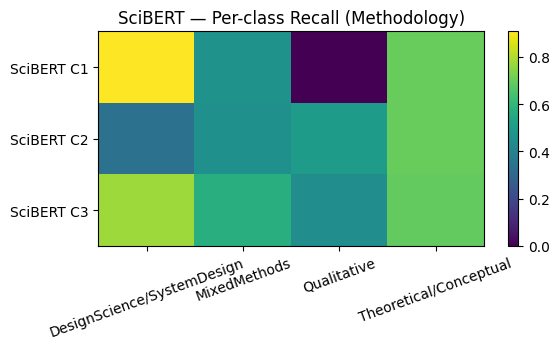

In [ ]:
# Upload CSV
from google.colab import files

uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded.")

fname, data = next(iter(uploaded.items()))
df = pd.read_csv(io.BytesIO(data))
print(f"Loaded: {fname}")

#  heatmap for SciBERT C-series
cols = [
    "recall_Design_Science_-_System_Design",
    "recall_Mixed_Methods",
    "recall_Qualitative",
    "recall_Theoretical_-_Conceptual",
]

required = {"run", *cols}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

order = ["C1_baseline_len256", "C2_lossweights_len256", "C3_combo_len256"]
df_c = df[df["run"].isin(order)].set_index("run").loc[order].reset_index()

# axis labels
pretty = ["DesignScience/SystemDesign", "MixedMethods", "Qualitative", "Theoretical/Conceptual"]

# heatmap
mat = df_c[cols].to_numpy()
plt.figure(figsize=(6, 3.6))
plt.imshow(mat, aspect="auto")
plt.xticks(range(len(pretty)), pretty, rotation=20)
plt.yticks(range(len(order)), ["SciBERT C1", "SciBERT C2", "SciBERT C3"])
plt.colorbar()
plt.title("SciBERT — Per-class Recall (Methodology)")
plt.tight_layout()
plt.show()

## 4.3 Roberta Model 1

I set up RoBERTa as a second transformer baseline for methodology classification using the same recipe as SciBERT for a clean comparison: an 80/20 split (seed=42), 512-token context to avoid truncation confounds, AdamW (2e-5) with small batches and gradient clipping, and a short 3-epoch run. Checkpoints were picked by validation accuracy for stability, while macro-F1 and per-class recall were logged for later analysis and plotting.

On this configuration the model reached val acc at about 0.806 and macro-F1 at about 0.532. Per-class recall was strong for Design Science/System Design (at about 0.90) and Theoretical/Conceptual (at about 0.75), moderate for Mixed Methods (at about 0.48), and weak for Qualitative (at 0) on this split. The pattern indicates RoBERTa’s general-domain pretraining transfers well to terminology-rich methodological cues, while very small or diffuse classes still require targeted treatment.

What this leads to next. Building on this baseline, I run three focused RoBERTa variants:

- D1 (baseline @256 tokens): halve the sequence length to test whether a shorter window preserves performance while improving efficiency (supported by the token-length study).

- D2 (loss weights): introduce class-weighted loss to raise minority recalls while monitoring for side effects on dominant classes.

- D3 (combo): combine reweighting with light warm-up/reshuffling to see if gains compound or trade off.

These controlled adjustments keep the backbone fixed and vary only training bias/length, so any shifts in macro-F1 or per-class recall can be attributed to the specific tweak rather than a wholesale change.

### Label Enconding and Tokenisation

Similar to my SciBERT's settings I used the same 80/20 split with a fixed seed so that RoBERTa Model 1 is comparable with SciBERT Model 1. I encode the LabelEncoder to lock class order to ensure the per-class recall columns line up across models.

I switch the backbone to roberta-base and tokenise to 512 tokens with max-length padding. RoBERTa is pre-trained on a larger and more diverse web corpus; the bet is that its sentence representations may capture non-domain-specific cues that help when abstracts are concise or less technical. Keeping 512 here mirrors the SciBERT Model 1 setup and avoids a confound from sequence length.

In [ ]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Prepare methodology subset
df_m = df[df['methodology'].notnull()].copy().reset_index(drop=True)
le = LabelEncoder()
df_m['label'] = le.fit_transform(df_m['methodology'])

# Dataset and split
dataset = Dataset.from_pandas(df_m[['processed_with_stopwords', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_ds, val_ds = dataset["train"], dataset["test"]

# Tokenisation (RoBERTa)
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 512

def tokenize(example):
    return tokenizer(
        example['processed_with_stopwords'],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize,   batched=True)

# Set format for PyTorch
cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch",   columns=cols)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

### Dataloaders and Checkpointing

Batches are small (4) due to 512-token sequences; this is the stable choice on Colab GPUs and keeps gradient noise manageable. I fine-tune with AdamW (lr=2e-5) and clip gradients at 1.0 to guard against early spikes while the classifier head is cold.

RoBERTa occasionally has a missing pad_token_id in the config; I set it from the tokenizer to prevent masking warnings and ensure consistent attention masks.

In [ ]:
# DataLoaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

# Model / Optimiser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)
).to(device)

# RoBERTa pad token safety check
if model.config.pad_token_id is None and tokenizer.pad_token_id is not None:
    model.config.pad_token_id = tokenizer.pad_token_id

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training + Validation per epoch
epochs = 3
best_val_acc = -1.0
best_state = None

for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validate
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["label"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train_loss: {avg_train_loss:.4f} | "
          f"val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f}")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01 | train_loss: 0.8051 | val_loss: 0.8655 | val_acc: 0.7529
Epoch 02 | train_loss: 0.7374 | val_loss: 0.8184 | val_acc: 0.7932
Epoch 03 | train_loss: 0.6601 | val_loss: 0.7511 | val_acc: 0.8057


### Evaluation and Logging

In [ ]:
# Load best weights
if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.extend(batch["label"].cpu().numpy())

print("\nValidation accuracy:", accuracy_score(labels, preds))
print(classification_report(labels, preds, target_names=le.classes_))

# Summary Table
val_acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)

row = {
    "run": "roberta_base_methodology_1run_len512",
    "max_len": 512,
    "lr": 2e-5,
    "train_loss": avg_train_loss,
    "val_loss": avg_val_loss,
    "val_acc": val_acc,
    "macro_f1": report["macro avg"]["f1-score"]
}
for label in le.classes_:
    row[f"recall_{label.replace(' ', '_')}"] = report[label]["recall"]

df_summary = pd.DataFrame([row])
csv_name = f"roberta_methodology_1run_summary_len512.csv"
df_summary.to_csv(csv_name, index=False)
print(f"\nSaved CSV summary to: {csv_name}")


Validation accuracy: 0.8057296329453895
                                precision    recall  f1-score   support

Design Science / System Design       0.86      0.90      0.88       685
                 Mixed Methods       0.49      0.48      0.48        94
                   Qualitative       0.00      0.00      0.00        18
      Theoretical / Conceptual       0.78      0.75      0.77       320

                      accuracy                           0.81      1117
                     macro avg       0.53      0.53      0.53      1117
                  weighted avg       0.79      0.81      0.80      1117


Saved CSV summary to: roberta_methodology_1run_summary_len512.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## 4.4 RoBERTa Extended Models (D1, D2, D3)

Starting from the RoBERTa 512-token baseline, I shifted to a 256 token window (per the token length study) and only altered training bias not the backbone to see whether minority recalls (Mixed Methods, Qualitative) could be raised without sinking overall behaviour.

Setup:
- D1, baseline @256, Cross-entropy with label smoothing 0.05, 6% warm-up, no sampler, no class weights. This is the un-rebalanced control.

- D2, class-weighted loss, Same schedule as D1, but the loss is inverse-frequency weighted so rare classes contribute more signal.

- D3, sampler + class weights + longer warm-up, WeightedRandomSampler (α = 0.5, cap = 6) to over-sample minority labels plus class-weighted loss and a 10% warm-up. This tweaks what each batch contains and how mistakes are penalised.

Observation:
- D1 keeps major labels strong (DS/SD at about 0.92, TC at about 0.79) but minorities trail (MM at about 0.23, Qual at 0). Macro-F1 at about 0.49, val acc at about 0.81.

- D2 is the most balanced overall: macro-F1 at about 0.57 with the highest accuracy (at about 0.83). DS/SD stays high (at about 0.88), MM improves (at about 0.62), TC remains solid (at about 0.83); Qual still doesn’t register on this split.

- D3 finally moves Qualitative (at about 0.33) and bumps MM further (at about 0.66), but DS/SD drops (at about 0.69) and TC softens (at about 0.59), so accuracy falls; macro-F1 at about 0.52.

Where this leaves the RoBERTa variants
256 tokens is a safe operating point for abstracts, and loss-weighting alone (D2) gives the best trade off meaningful minority gains without eroding dominant classes.

### Set Up and Utilities

In [ ]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Configuration Dataclass
@dataclass
class RunConfig:
    name: str
    model_name: str = "roberta-base"
    max_len: int = 256
    batch_size: int = 4
    lr: float = 2e-5
    weight_decay: float = 0.01
    epochs: int = 6
    patience: int = 2
    label_smoothing: float = 0.0
    use_sampler: bool = False
    sampler_alpha: float = 0.5
    sampler_cap: float = 6.0
    use_loss_weights: bool = False
    warmup_frac: float = 0.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2
    pin_memory: bool = True

### Tokenisation and DataLoaders

I tokenise with RoBERTa’s tokenizer at 256 tokens using max-length padding to keep batch shapes stable on Colab. The DataLoader is standard shuffling for D1/D2; for D3 I build a WeightedRandomSampler from class counts so minority labels appear more often in each batch (tempered by α and capped, to avoid degeneracy).
The loss matches each run: D1 uses cross-entropy with label smoothing; D2 and D3 use class-weighted cross-entropy, where weights are the normalised inverse of class frequencies so rare labels contribute more signal without exploding the scale.

In [ ]:
def _tok_fn(tokenizer, max_len):
    def _inner(ex):
        return tokenizer(
            ex["processed_with_stopwords"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )
    return _inner

def build_loaders(train_ds, val_ds, cfg: RunConfig, tokenizer, num_classes: int):
    train_tok = train_ds.map(_tok_fn(tokenizer, cfg.max_len), batched=True)
    val_tok   = val_ds.map(_tok_fn(tokenizer, cfg.max_len),   batched=True)
    cols = ["input_ids","attention_mask","label"]
    train_tok.set_format(type="torch", columns=cols)
    val_tok.set_format(type="torch",   columns=cols)

    if cfg.use_sampler:
        train_labels = np.array(train_tok["label"])
        class_counts = np.bincount(train_labels, minlength=num_classes)
        class_counts[class_counts == 0] = 1
        w_class = 1.0 / np.power(class_counts.astype(np.float64), cfg.sampler_alpha)
        w_class = w_class / w_class.mean()
        w_class = np.minimum(w_class, cfg.sampler_cap)
        sample_weights = w_class[train_labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_tok, batch_size=cfg.batch_size, sampler=sampler,
                                  num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
    else:
        train_loader = DataLoader(train_tok, batch_size=cfg.batch_size, shuffle=True,
                                  num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

    val_loader = DataLoader(val_tok, batch_size=cfg.batch_size, shuffle=False,
                            num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
    return train_loader, val_loader

def build_loss(cfg: RunConfig, train_loader, num_classes: int):
    weight = None
    if cfg.use_loss_weights:
        labels = np.array(train_loader.dataset["label"])
        counts = np.bincount(labels, minlength=num_classes)
        counts[counts == 0] = 1
        raw_w  = (len(labels) / (num_classes * counts.astype(np.float64)))
        norm_w = raw_w / raw_w.mean()
        weight = torch.tensor(norm_w, dtype=torch.float, device=cfg.device)

    try:
        return nn.CrossEntropyLoss(weight=weight, label_smoothing=cfg.label_smoothing)
    except TypeError:
        return nn.CrossEntropyLoss(weight=weight)

### Runner

For each config I fine-tune with AdamW, a linear warm-up (per the run’s fraction), and gradient clipping at 1.0. I monitor validation loss each epoch and use early stopping (patience=2) to avoid overfitting the fold. After restoring the best-loss checkpoint, I compute accuracy, macro-F1, and per-class recall via classification_report. Each run writes a one-row summary to a CSV with the training knobs, val_acc, macro_f1, val_loss, and the four recalls (Design Science/System Design, Mixed Methods, Qualitative, Theoretical/Conceptual).
Keeping this schema identical to the SciBERT extended runs lets me drop these rows straight into the Section 5 tables/plots (macro-F1 bars and per-class recall heatmaps) without additional wrangling.

In [ ]:
def run_3_configs_for_label_roberta(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    assert "processed_with_stopwords" in df.columns and label_col in df.columns

    set_seed(42)
    df_task = df[df[label_col].notnull()].copy().reset_index(drop=True)
    le = LabelEncoder()
    df_task["label"] = le.fit_transform(df_task[label_col])
    num_classes = len(le.classes_)

    full_ds = Dataset.from_pandas(df_task[["processed_with_stopwords","label"]])
    splits  = full_ds.train_test_split(test_size=0.2, seed=42)
    train_ds, val_ds = splits["train"], splits["test"]

    runs: List[RunConfig] = [
        RunConfig(name="D1_baseline_len256", lr=3e-5, warmup_frac=0.06, label_smoothing=0.05),
        RunConfig(name="D2_lossweights_len256", lr=2e-5, warmup_frac=0.06, use_loss_weights=True),
        RunConfig(name="D3_combo_len256", lr=1e-5, warmup_frac=0.10, use_sampler=True,
                  use_loss_weights=True, sampler_alpha=0.5, sampler_cap=6.0),
    ]
    def run_once(cfg: RunConfig) -> Dict[str, Any]:
        set_seed(42)
        t0 = time.time()

        tokenizer = AutoTokenizer.from_pretrained(cfg.model_name, use_fast=True)
        train_loader, val_loader = build_loaders(train_ds, val_ds, cfg, tokenizer, num_classes)
        model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=num_classes).to(cfg.device)
        if model.config.pad_token_id is None and tokenizer.pad_token_id is not None:
            model.config.pad_token_id = tokenizer.pad_token_id

        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        total_steps = len(train_loader) * cfg.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(cfg.warmup_frac * total_steps),
            num_training_steps=total_steps
        ) if cfg.warmup_frac and total_steps > 0 else None

        loss_fct = build_loss(cfg, train_loader, num_classes)

        best_val_loss = float("inf"); best_state = None; patience_ctr = 0

        for epoch in range(1, cfg.epochs + 1):
            model.train(); tr_loss = 0.0
            for batch in train_loader:
                optimizer.zero_grad()
                batch = {k: v.to(cfg.device) for k, v in batch.items()}
                out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                loss = loss_fct(out.logits, batch["label"])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None: scheduler.step()
                tr_loss += loss.item()
            avg_tr = tr_loss / max(1, len(train_loader))

            model.eval(); va_loss = 0.0; preds, labels = [], []
            with torch.no_grad():
                for batch in val_loader:
                    batch = {k: v.to(cfg.device) for k, v in batch.items()}
                    out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                    loss = loss_fct(out.logits, batch["label"])
                    va_loss += loss.item()
                    preds.extend(torch.argmax(out.logits, dim=-1).cpu().numpy())
                    labels.extend(batch["label"].cpu().numpy())
            avg_va = va_loss / max(1, len(val_loader))
            val_acc = accuracy_score(labels, preds)

            print(f"[{label_col} | {cfg.name}] Epoch {epoch:02d} | train_loss: {avg_tr:.4f} | "
                  f"val_loss: {avg_va:.4f} | val_acc: {val_acc:.4f} | patience {patience_ctr}/{cfg.patience}")

            if avg_va < best_val_loss:
                best_val_loss = avg_va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= cfg.patience:
                    print(f"[{label_col} | {cfg.name}] Early stopping.")
                    break
        if best_state is not None:
            model.load_state_dict(best_state)

        model.eval(); preds, labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(cfg.device) for k, v in batch.items()}
                logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
                preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
                labels.extend(batch["label"].cpu().numpy())

        rep = classification_report(labels, preds, target_names=list(le.classes_),
                                    output_dict=True, zero_division=0)
        macro_f1 = rep["macro avg"]["f1-score"]
        per_class = {f"recall_{cls.replace('/', '-').replace(' ', '_')}": rep[cls]["recall"] for cls in le.classes_}

        row = {
            "run": cfg.name, "max_len": cfg.max_len, "lr": cfg.lr,
            "warmup": cfg.warmup_frac, "sampler": cfg.use_sampler,
            "alpha": cfg.sampler_alpha if cfg.use_sampler else 0.0,
            "loss_weights": cfg.use_loss_weights, "val_acc": rep["accuracy"],
            "macro_f1": macro_f1, "val_loss": round(best_val_loss, 4)
        }
        row.update(per_class)
        return row

    rows = [run_once(cfg) for cfg in runs]
    summary = pd.DataFrame(rows).sort_values(by=["macro_f1", "val_acc"], ascending=False).reset_index(drop=True)

    front = ["run", "max_len", "lr", "warmup", "sampler", "alpha", "loss_weights", "val_acc", "macro_f1", "val_loss"]
    recalls = [c for c in summary.columns if c.startswith("recall_")]
    summary = summary[front + recalls]

    display(summary)
    out_csv = f"roBERTa_{label_col}_D123_summary_len256.csv"
    summary.to_csv(out_csv, index=False)
    print(f"Saved summary to: {out_csv}")
    return summary

# Run for "methodology" label
summary_methodology = run_3_configs_for_label_roberta(df, "methodology")


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[methodology | D1_baseline_len256] Epoch 01 | train_loss: 0.8922 | val_loss: 0.8550 | val_acc: 0.7538 | patience 0/2
[methodology | D1_baseline_len256] Epoch 02 | train_loss: 0.8023 | val_loss: 0.8692 | val_acc: 0.7645 | patience 0/2
[methodology | D1_baseline_len256] Epoch 03 | train_loss: 0.7653 | val_loss: 0.8305 | val_acc: 0.7833 | patience 1/2
[methodology | D1_baseline_len256] Epoch 04 | train_loss: 0.7035 | val_loss: 0.7584 | val_acc: 0.7968 | patience 0/2
[methodology | D1_baseline_len256] Epoch 05 | train_loss: 0.6317 | val_loss: 0.7445 | val_acc: 0.8093 | patience 0/2
[methodology | D1_baseline_len256] Epoch 06 | train_loss: 0.5802 | val_loss: 0.7514 | val_acc: 0.8245 | patience 0/2


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[methodology | D2_lossweights_len256] Epoch 01 | train_loss: 1.1331 | val_loss: 1.1528 | val_acc: 0.7619 | patience 0/2
[methodology | D2_lossweights_len256] Epoch 02 | train_loss: 1.0618 | val_loss: 0.9688 | val_acc: 0.8093 | patience 0/2
[methodology | D2_lossweights_len256] Epoch 03 | train_loss: 0.9128 | val_loss: 0.9445 | val_acc: 0.8326 | patience 0/2
[methodology | D2_lossweights_len256] Epoch 04 | train_loss: 0.7617 | val_loss: 1.0519 | val_acc: 0.8371 | patience 0/2
[methodology | D2_lossweights_len256] Epoch 05 | train_loss: 0.6045 | val_loss: 1.1705 | val_acc: 0.8389 | patience 1/2
[methodology | D2_lossweights_len256] Early stopping.


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[methodology | D3_combo_len256] Epoch 01 | train_loss: 1.2340 | val_loss: 1.0149 | val_acc: 0.6509 | patience 0/2
[methodology | D3_combo_len256] Epoch 02 | train_loss: 0.7737 | val_loss: 1.2235 | val_acc: 0.7538 | patience 0/2
[methodology | D3_combo_len256] Epoch 03 | train_loss: 0.5177 | val_loss: 1.2021 | val_acc: 0.8039 | patience 1/2
[methodology | D3_combo_len256] Early stopping.


,run,max_len,lr,warmup,sampler,alpha,loss_weights,val_acc,macro_f1,val_loss,recall_Design_Science_-_System_Design,recall_Mixed_Methods,recall_Qualitative,recall_Theoretical_-_Conceptual
0,D2_lossweights_len256,256,0.00002,0.06,False,0.0,True,0.832587,0.573381,0.9445,0.884672,0.617021,0.000000,0.831250
1,D3_combo_len256,256,0.00001,0.10,True,0.5,True,0.650850,0.521147,1.0149,0.686131,0.659574,0.333333,0.590625
2,D1_baseline_len256,256,0.00003,0.06,False,0.0,False,0.809311,0.493228,0.7445,0.919708,0.234043,0.000000,0.787500


Saved summary to: roBERTa_methodology_D123_summary_len256.csv


Saving B2_roBERTa_methodology_D123_summary_len256.csv to B2_roBERTa_methodology_D123_summary_len256.csv
Loaded: B2_roBERTa_methodology_D123_summary_len256.csv


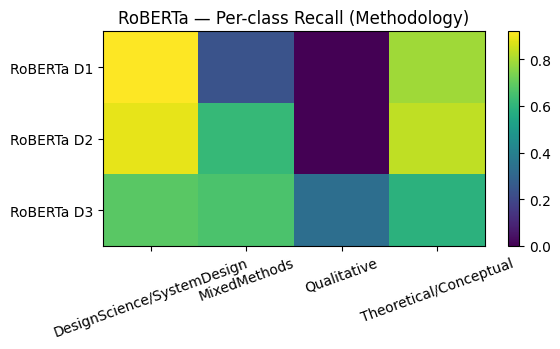

In [ ]:
# Upload CSV
from google.colab import files

uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded.")

# multiple files uploaded
fname, data = next(iter(uploaded.items()))
df = pd.read_csv(io.BytesIO(data))
print(f"Loaded: {fname}")

# Build heatmap for RoBERTa
# Required columns
cols = [
    "recall_Design_Science_-_System_Design",
    "recall_Mixed_Methods",
    "recall_Qualitative",
    "recall_Theoretical_-_Conceptual",
]

required = {"run", *cols}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")


order = ["D1_baseline_len256", "D2_lossweights_len256", "D3_combo_len256"]
df_c = df[df["run"].isin(order)].set_index("run").loc[order].reset_index()

# axis labels
pretty = ["DesignScience/SystemDesign", "MixedMethods", "Qualitative", "Theoretical/Conceptual"]

# Plot heatmap
mat = df_c[cols].to_numpy()
plt.figure(figsize=(6, 3.6))
plt.imshow(mat, aspect="auto")
plt.xticks(range(len(pretty)), pretty, rotation=20)
plt.yticks(range(len(order)), ["RoBERTa D1", "RoBERTa D2", "RoBERTa D3"])
plt.colorbar()
plt.title("RoBERTa — Per-class Recall (Methodology)")
plt.tight_layout()
plt.show()

## 4.5 DistilBERT Model 1

I set up DistilBERT as a lighter transformer baseline using the same recipe as the other Model 1 runs for a fair comparison: an 80/20 split (seed=42), 512-token context to avoid truncation effects, AdamW (2e-5) with small batches and gradient clipping, and a short 3-epoch fine-tune. I select the checkpoint by validation accuracy for stability, while logging macro-F1 and per-class recall to feed into later plots.

On this configuration the model reached val acc at about 0.829 and macro-F1 at about 0.56. Recall was strong for Theoretical/Conceptual (at about 0.85) and Design Science/System Design (at about 0.88), and notably higher on Mixed Methods (at about 0.56) than the other baselines, while Qualitative remained low on this split. The result shows that even a compact encoder can capture most methodology cues well when given full-abstract context, offering a solid speed/size trade-off without a large drop in headline metrics.

With a compact model delivering near-SciBERT accuracy and fast runtime, I keep the training recipe fixed and move on to the extended DistilBERT variants (E1–E3) to test whether mild rebalancing and schedule tweaks can raise minority recalls without paying a large stability cost.

### Tokenisation

Tokenisation uses distilbert-base-uncased at max_len=512 with padding="max_length" and truncation matching the other Model 1 baselines so differences come from pretraining rather than preprocessing.

In [ ]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Load and preprocess
df_m = df[df['methodology'].notnull()].copy().reset_index(drop=True)
le = LabelEncoder()
df_m['label'] = le.fit_transform(df_m['methodology'])

dataset = Dataset.from_pandas(df_m[['processed_with_stopwords', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_ds, val_ds = dataset["train"], dataset["test"]

# Tokenisation
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example['processed_with_stopwords'],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

### Training Loop

I build PyTorch DataLoaders (batch=4), AutoModelForSequenceClassification with AdamW(2e-5), and clip grads at 1.0. I track val accuracy each epoch and remember the best weights, short schedules on modest data tend to overfit if trained longer; picking the best epoch acts as a light early-stopping guard.

In [ ]:
# Dataloaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

# Model / Optimiser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training
epochs = 3
best_val_acc = -1.0
best_state = None

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["label"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01 | train_loss: 0.7041 | val_loss: 0.7227 | val_acc: 0.7878
Epoch 02 | train_loss: 0.5476 | val_loss: 0.6577 | val_acc: 0.8201
Epoch 03 | train_loss: 0.4154 | val_loss: 0.6752 | val_acc: 0.8290


### Evaluation and Logging

After restoring the best state, I compute the classification report and extract: val_acc, macro-F1, and per-class recall for the four methodology labels. I export a one-row CSV this keeps plotting code simple and makes the DistilBERT row drop-in compatible to be used later.

In [ ]:
# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

# Final Evaluation
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        ).logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        labels.extend(batch["label"].cpu().numpy())

val_acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)

# Print report to console
print("\nValidation accuracy:", val_acc)
print(classification_report(labels, preds, target_names=le.classes_))

# Build Summary Table and Export CSV
row = {
    "run": "distilbert_base_len512",
    "max_len": 512,
    "lr": 2e-5,
    "train_loss": avg_train_loss,
    "val_loss": avg_val_loss,
    "val_acc": val_acc,
    "macro_f1": report["macro avg"]["f1-score"]
}
for label in le.classes_:
    row[f"recall_{label.replace(' ', '_')}"] = report[label]["recall"]

df_summary = pd.DataFrame([row])
csv_name = "distilBERT_methodology_1run_summary_len512.csv"
df_summary.to_csv(csv_name, index=False)
print(f"\nSaved CSV summary to: {csv_name}")



Validation accuracy: 0.8290062667860341
                                precision    recall  f1-score   support

Design Science / System Design       0.92      0.88      0.90       685
                 Mixed Methods       0.56      0.56      0.56        94
                   Qualitative       0.00      0.00      0.00        18
      Theoretical / Conceptual       0.74      0.85      0.79       320

                      accuracy                           0.83      1117
                     macro avg       0.55      0.57      0.56      1117
                  weighted avg       0.82      0.83      0.82      1117


Saved CSV summary to: distilBERT_methodology_1run_summary_len512.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## 4.6 DistilBERT Extended Models (E1, E2, E3)
After confirming DistilBERT is competitive at 512 tokens, I re-ran it at 256 tokens (supported by the token-length study) and varied only the optimisation bias, not the architecture, to test whether we can lift minority recalls without sacrificing overall reliability.

Setup:
- E1 (baseline @ 256): plain cross-entropy, no warm-up, no class weights, no sampler. Control run at the shorter sequence length.

- E2 (scheduler): same as E1 plus 10% linear warm-up to stabilise the first few hundred updates when the classifier head is untrained.

- E3 (class-weighted loss): same as E1 with inverse-frequency class weights in the loss to increase gradient signal for rarer labels. (No sampler.)

Observation:
- E1 gives the best balance (macro-F1 at about 0.562; DS/SD at about 0.94, MM at about 0.43, Qual at about 0.06, TC at about 0.72).

- E2 slightly improves overall accuracy (val acc at about 0.826) and MM recall (at about 0.47) but lowers macro-F1 (at about 0.546) because Qualitative drops to zero on this split.

- E3 increases the penalty on mistakes for rarer labels but, without a sampler, doesn’t reliably lift minority recall here; macro-F1 falls (at about 0.474).

These runs confirm that 256 tokens is a safe operating point for DistilBERT on abstracts and that light schedule tweaks (warm-up) help stability, while class-weighted loss alone is insufficient to close the gap on the smallest class.

### Configuaration

A small RunConfig dataclass centralises everything that defines a run: model name (distilbert-base-uncased), max sequence length (256), batch size, learning rate, warm up fraction, and whether class weights are used. This keeps experiments reproducible and makes it easy to change a single factor at a time. The tokenize_fn wraps the DistilBERT tokenizer with truncation and max-length padding so batches are uniform and memory predictable. The build_loss function returns either plain cross entropy (E1, E2) or a class weighted variant (E3). I compute inverse frequency weights from the training split and normalise them so the average weight is one; that preserves loss scale and keeps gradient magnitudes comparable across runs.

In [ ]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)

# Config
@dataclass
class RunConfig:
    name: str
    model_name: str = "distilbert-base-uncased"
    max_len: int = 256
    batch_size: int = 4
    lr: float = 2e-5
    weight_decay: float = 0.01
    epochs: int = 6
    patience: int = 2
    warmup_frac: float = 0.0
    use_loss_weights: bool = False
    use_sampler: bool = False
    sampler_alpha: float = 0.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Tokeniser and Loss
def tokenize_fn(tokenizer, max_len):
    def f(example):
        return tokenizer(
            example["processed_with_stopwords"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )
    return f

def build_loss(cfg: RunConfig, label_counts: np.ndarray):
    if not cfg.use_loss_weights:
        return nn.CrossEntropyLoss()
    weights = 1.0 / (label_counts + 1e-5)
    norm_weights = weights / weights.mean()
    weight_tensor = torch.tensor(norm_weights, dtype=torch.float).to(cfg.device)
    return nn.CrossEntropyLoss(weight=weight_tensor)


### Runner

The runner creates a single 80/20 split (seed=42) for the chosen label and reuses it across E1–E3 so differences reflect training bias only. Training proceeds for up to six epochs with gradient clipping at 1.0; validation loss is monitored each epoch and the best state is kept with patience set to two epochs. This criterion is conservative and model-agnostic, which helps when comparing heterogeneous tweaks. After training, the best checkpoint is reloaded and evaluated to produce accuracy, macro-F1, and per-class recalls.

In [ ]:
# Main Runner
def run_3_configs_for_label_distilbert(df: pd.DataFrame, label_col: str):
    set_seed(42)
    assert 'processed_with_stopwords' in df.columns

    df_task = df[df[label_col].notnull()].copy().reset_index(drop=True)
    le = LabelEncoder()
    df_task['label'] = le.fit_transform(df_task[label_col])
    num_classes = len(le.classes_)
    full_ds = Dataset.from_pandas(df_task[['processed_with_stopwords', 'label']])
    splits = full_ds.train_test_split(test_size=0.2, seed=42)
    train_ds, val_ds = splits['train'], splits['test']

    runs = [
        RunConfig(name="E1_len256"),
        RunConfig(name="E2_scheduler_len256", warmup_frac=0.1),
        RunConfig(name="E3_classweights_len256", use_loss_weights=True),
    ]

    results = []
    for cfg in runs:
        set_seed(42)

        tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
        tokenized_train = train_ds.map(tokenize_fn(tokenizer, cfg.max_len), batched=True)
        tokenized_val = val_ds.map(tokenize_fn(tokenizer, cfg.max_len), batched=True)

        tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        train_loader = DataLoader(tokenized_train, batch_size=cfg.batch_size, shuffle=True)
        val_loader = DataLoader(tokenized_val, batch_size=cfg.batch_size)

        model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=num_classes).to(cfg.device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        total_steps = len(train_loader) * cfg.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(cfg.warmup_frac * total_steps),
            num_training_steps=total_steps
        ) if cfg.warmup_frac else None

        label_counts = np.bincount(df_task['label'], minlength=num_classes)
        loss_fct = build_loss(cfg, label_counts)

        best_val_loss = float('inf'); best_state = None; patience_ctr = 0
        for epoch in range(1, cfg.epochs + 1):
            model.train(); total_train_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                batch = {k: v.to(cfg.device) for k, v in batch.items()}
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                loss = loss_fct(outputs.logits, batch['label'])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler: scheduler.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)

            # Validation
            model.eval(); total_val_loss, preds, labels = 0, [], []
            with torch.no_grad():
                for batch in val_loader:
                    batch = {k: v.to(cfg.device) for k, v in batch.items()}
                    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                    loss = loss_fct(outputs.logits, batch["label"])
                    total_val_loss += loss.item()
                    preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
                    labels.extend(batch["label"].cpu().numpy())
            avg_val_loss = total_val_loss / len(val_loader)
            val_acc = accuracy_score(labels, preds)

            print(f"[{cfg.name}] Epoch {epoch} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f} | patience {patience_ctr}/{cfg.patience}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= cfg.patience:
                    break

        # Final Evaluation
        if best_state:
            model.load_state_dict(best_state)
        model.eval(); preds, labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(cfg.device) for k, v in batch.items()}
                logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
                preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
                labels.extend(batch["label"].cpu().numpy())

        report = classification_report(labels, preds, target_names=list(le.classes_), output_dict=True, zero_division=0)
        macro_f1 = report["macro avg"]["f1-score"]

        row = {
            "run": cfg.name,
            "max_len": cfg.max_len,
            "lr": cfg.lr,
            "warmup": cfg.warmup_frac,
            "sampler": cfg.use_sampler,
            "alpha": cfg.sampler_alpha,
            "loss_weights": cfg.use_loss_weights,
            "val_acc": report["accuracy"],
            "macro_f1": macro_f1,
            "val_loss": round(best_val_loss, 4),
        }
        for cls in le.classes_:
            safe_name = cls.replace("/", "-").replace(" ", "_")
            row[f"recall_{safe_name}"] = report[cls]["recall"]
        results.append(row)

    df_summary = pd.DataFrame(results).sort_values(by=["macro_f1","val_acc"], ascending=False).reset_index(drop=True)
    front = ["run","max_len","lr","warmup","sampler","alpha","loss_weights","val_acc","macro_f1","val_loss"]
    recall_cols = [c for c in df_summary.columns if c.startswith("recall_")]
    df_summary = df_summary[front + recall_cols]

    out_csv = f"distilBERT_{label_col}_E123_summary_len256.csv"
    df_summary.to_csv(out_csv, index=False)
    print(f"\nSaved summary to: {out_csv}")
    display(df_summary)
    return df_summary

# Run the experiment
df_summary = run_3_configs_for_label_distilbert(df, "methodology")
# Export to CSV
df_summary.to_csv("distilBERT_methodology_E123_summary.csv", index=False)
print("Saved summary to: distilBERT_methodology_E123_summary.csv")


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[E1_len256] Epoch 1 | train_loss: 0.7109 | val_loss: 0.7078 | val_acc: 0.7842 | patience 0/2
[E1_len256] Epoch 2 | train_loss: 0.5366 | val_loss: 0.6884 | val_acc: 0.8201 | patience 0/2
[E1_len256] Epoch 3 | train_loss: 0.4152 | val_loss: 0.7050 | val_acc: 0.8183 | patience 0/2
[E1_len256] Epoch 4 | train_loss: 0.3037 | val_loss: 0.8426 | val_acc: 0.8371 | patience 1/2


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[E2_scheduler_len256] Epoch 1 | train_loss: 0.7872 | val_loss: 0.7535 | val_acc: 0.7672 | patience 0/2
[E2_scheduler_len256] Epoch 2 | train_loss: 0.5770 | val_loss: 0.6076 | val_acc: 0.8263 | patience 0/2
[E2_scheduler_len256] Epoch 3 | train_loss: 0.4148 | val_loss: 0.7104 | val_acc: 0.8263 | patience 0/2
[E2_scheduler_len256] Epoch 4 | train_loss: 0.2859 | val_loss: 0.8340 | val_acc: 0.8371 | patience 1/2


Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[E3_classweights_len256] Epoch 1 | train_loss: 1.0332 | val_loss: 1.0185 | val_acc: 0.7914 | patience 0/2
[E3_classweights_len256] Epoch 2 | train_loss: 0.8714 | val_loss: 1.0202 | val_acc: 0.8236 | patience 0/2
[E3_classweights_len256] Epoch 3 | train_loss: 0.6899 | val_loss: 1.1439 | val_acc: 0.8147 | patience 1/2

Saved summary to: distilBERT_methodology_E123_summary_len256.csv


,run,max_len,lr,warmup,sampler,alpha,loss_weights,val_acc,macro_f1,val_loss,recall_Design_Science_-_System_Design,recall_Mixed_Methods,recall_Qualitative,recall_Theoretical_-_Conceptual
0,E1_len256,256,0.00002,0.0,False,0.0,False,0.820054,0.561651,0.6884,0.943066,0.425532,0.055556,0.715625
1,E2_scheduler_len256,256,0.00002,0.1,False,0.0,False,0.826321,0.546284,0.6076,0.908029,0.468085,0.000000,0.803125
2,E3_classweights_len256,256,0.00002,0.0,False,0.0,True,0.791406,0.474184,1.0185,0.929927,0.202128,0.000000,0.712500


Saved summary to: distilBERT_methodology_E123_summary.csv


Saving C2_distilBERT_methodology_E123_summary.csv to C2_distilBERT_methodology_E123_summary.csv
Loaded: C2_distilBERT_methodology_E123_summary.csv


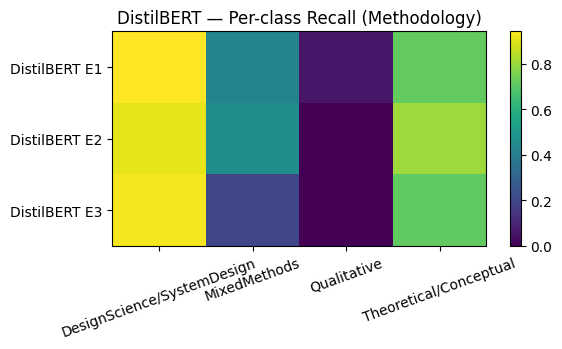

In [ ]:
# Upload CSV
from google.colab import files

uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded.")

# multiple files upload
fname, data = next(iter(uploaded.items()))
df = pd.read_csv(io.BytesIO(data))
print(f"Loaded: {fname}")

# Build heatmap for DistilBERT
# Required columns
cols = [
    "recall_Design_Science_-_System_Design",
    "recall_Mixed_Methods",
    "recall_Qualitative",
    "recall_Theoretical_-_Conceptual",
]

required = {"run", *cols}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

order = ["E1_len256", "E2_scheduler_len256", "E3_classweights_len256"]
df_c = df[df["run"].isin(order)].set_index("run").loc[order].reset_index()

# axis labels
pretty = ["DesignScience/SystemDesign", "MixedMethods", "Qualitative", "Theoretical/Conceptual"]

# Plot heatmap
mat = df_c[cols].to_numpy()
plt.figure(figsize=(6, 3.6))
plt.imshow(mat, aspect="auto")
plt.xticks(range(len(pretty)), pretty, rotation=20)
plt.yticks(range(len(order)), ["DistilBERT E1", "DistilBERT E2", "DistilBERT E3"])
plt.colorbar()
plt.title("DistilBERT — Per-class Recall (Methodology)")
plt.tight_layout()
plt.show()

# 5. Model Comparisons

This section compare baselines and extensions using the same preprocessed data and the same 80/20 split (seed=42). The goal is to show outcomes side-by-side and explain what those outcomes mean for the project.

Evaluation lens.

- Macro-F1 (equal weight per class). This reflects the project’s need to recognise all methodology types rather than optimise only for the majority label.

- Overall validation accuracy (stability) and per-class recall (who benefits or suffers).

- Identical preprocessing; fixed token length within each comparison (512 for the “Model 1” baselines; 256 for extended C/D/E runs); same random seed; and no re-tuning between models beyond the planned knobs in Section 4.

In this section we discuss the following:

- 5.1 TF-IDF vs SciBERT Model 1. A head-to-head to show what modern pretraining buys over a strong linear baseline using identical labels and metrics.

- 5.2 Transformer Model 1’s. SciBERT vs RoBERTa vs DistilBERT at the same setup to separate architecture/pretraining effects from training tricks.

- 5.3 All Models, Macro-F1. A single horizontal bar chart for every run (baselines + C/D/E variants) to reveal the ranking at a glance.

- 5.4 All Models, Per-Class Recall. A heatmap to inspect trade-offs: e.g., whether gains on Mixed Methods or Qualitative come at the expense of Design Science / System Design.


The comparisons prioritise models that lift minority recalls without collapsing majority performance. In practice, that means macro-F1 leads the decision, with recall heatmaps as the tie-breaker. You’ll see that the baseline SciBERT Model 1 remains a strong all-rounder under this lens; some RoBERTa and DistilBERT variants provide interesting trade-offs (e.g., slightly higher accuracy or better recall on specific classes) that are worth noting depending on deployment constraints.

## 5.1 TF-IDF vs Transformer (SciBERT Model 1)

I put SciBERT Model 1 against two TF-IDF baselines (TF-IDF Basic and TF-IDF KFold). All use the same label space and evaluation on the methodology task.

- Macro-F1: SciBERT ≈ 0.59 vs TF-IDF ≈ 0.39 / 0.38.
- Val. accuracy: SciBERT ≈ 0.82 vs TF-IDF ≈ 0.756–0.759.

- Per-class recall:
  - Design Science/System Design: 0.946 (SciBERT) vs ~0.931 (both TF-IDF).
  - Mixed Methods: ~0.35 (SciBERT) vs 0.044 / 0.018 (TF-IDF).
  - Qualitative: ~0.17 (SciBERT) vs 0.00 / 0.00 (TF-IDF).
  - Theoretical/Conceptual: ~0.73 (SciBERT) vs ~0.57 / 0.59 (TF-IDF).

The bar and radar charts tell the same story: TF-IDF holds up on the majority class (DS/SD) but collapses on the small, diffuse categories (Mixed Methods, Qualitative). SciBERT’s contextual representations pretrained on scientific text recover signal that isn’t tied to specific keywords (e.g., multi-clause descriptions of study design, hedging, or reasoning verbs), so minority recalls rise without losing the strong DS/SD performance. Cross-validation on TF-IDF doesn’t fix the issue because the limitation is representational, not just variance from a single split.

Saving A1_scibert_methodology_1run_summary_len512.csv to A1_scibert_methodology_1run_summary_len512 (4).csv
Saving tfidf_basic_methodology_metrics.csv to tfidf_basic_methodology_metrics (4).csv
Saving tfidf_kfold_methodology_metrics.csv to tfidf_kfold_methodology_metrics (4).csv


,run,val_acc,macro_f1,Recall_DS/SD,Recall_MM,Recall_Qual,Recall_TC
0,scibert_base_methodology_1run_len512,0.820054,0.594046,0.945985,0.351064,0.166667,0.725000
1,TFIDF_basic,0.756491,0.390160,0.934813,0.044444,0.000000,0.566102
2,TFIDF_kfold,0.758689,0.381373,0.931408,0.017778,0.000000,0.591063


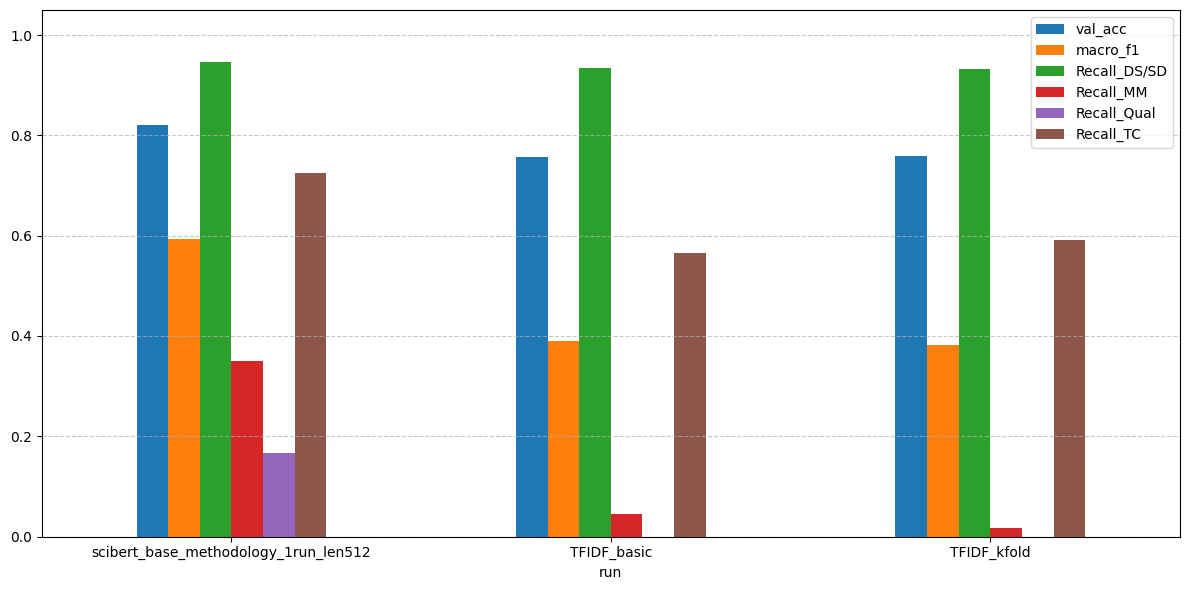

In [ ]:
from google.colab import files
# Upload one or more CSVs
up = files.upload()

# Read → keep only TF-IDF metric set → stack
dfs = []
for _, data in up.items():
    df = pd.read_csv(io.BytesIO(data))
    keep = [c for c in df.columns if c == "run" or c in ("val_acc", "macro_f1") or c.lower().startswith("recall_")]
    dfs.append(df[keep])

combined = pd.concat(dfs, ignore_index=True)
combined = combined[
    ["run"]
    + [c for c in ("val_acc", "macro_f1") if c in combined.columns]
    + [c for c in combined.columns if c.lower().startswith("recall_")]
]

# Rename recalls for display
combined = combined.rename(columns={
    "recall_Design_Science_/_System_Design": "Recall_DS/SD",
    "recall_Mixed_Methods": "Recall_MM",
    "recall_Qualitative": "Recall_Qual",
    "recall_Theoretical_/_Conceptual": "Recall_TC",
})

# Round + show
num_cols = combined.select_dtypes("number").columns
combined[num_cols] = combined[num_cols].round(6)
display(combined)

# Plot
metrics = [c for c in ["val_acc","macro_f1","Recall_DS/SD","Recall_MM","Recall_Qual","Recall_TC"] if c in combined.columns]
combined.set_index("run")[metrics].plot(kind="bar", figsize=(12,6), rot=0)
plt.ylim(0, 1.05); plt.grid(axis="y", linestyle="--", alpha=0.7); plt.tight_layout(); plt.show()

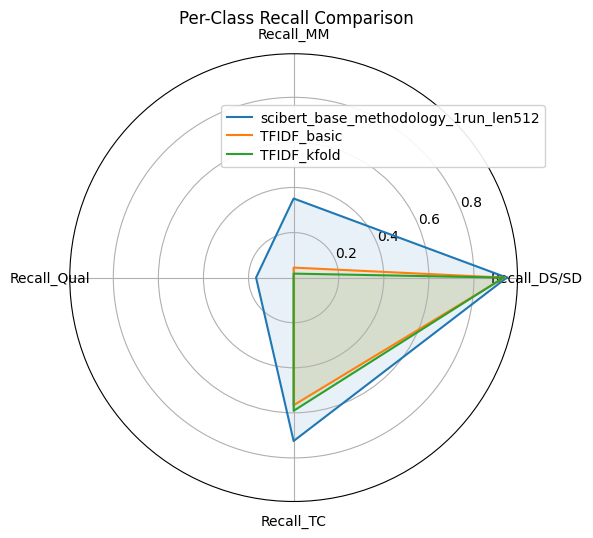

In [ ]:
#  Spider plot
labels = ["Recall_DS/SD", "Recall_MM", "Recall_Qual", "Recall_TC"]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.append(angles, angles[0])

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for _, row in combined.iterrows():
    vals = row[labels].astype(float).fillna(0).to_numpy()
    vals = np.append(vals, vals[0])
    ax.plot(angles, vals, label=str(row["run"]))
    ax.fill(angles, vals, alpha=0.10)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Title position
plt.suptitle("Per-Class Recall Comparison", x=0.5, y=0.92)

# legend
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.7, 0.9),
    frameon=True, fancybox=True, framealpha=0.9,
    borderpad=0.4, labelspacing=0.3, handlelength=1.8, handletextpad=0.6,
    ncol=1, fontsize=10
)

plt.tight_layout()
plt.show()

## 5.2 Transformer Model 1’s

Here I held the training recipe constant same split (seed=42), 512-token window, AdamW 2e-5 for 3 epochs with gradient clipping and swapped only the backbone. The three models bring different priors: SciBERT is pretrained on scientific text and vocabulary; RoBERTa is a robustly-trained general-domain encoder; DistilBERT is a distilled, shallower student of BERT that trades capacity for speed.

- DistilBERT posts the highest validation accuracy (at about 0.829). That number is driven by strong performance on the frequent labels Theoretical/Conceptual (at about 0.85 recall) and a solid Design Science/System Design (at about 0.88) and the best Mixed Methods recall (at about 0.56) of the three. But it never picks Qualitative (0.00 recall) on this split. Accuracy remains high because most instances are not Qualitative; macro-F1 (which weights classes equally) drops to at about 0.56 and exposes that blind spot. In other words, DistilBERT is confident and efficient on the dominant signal, but its decision boundary essentially excludes the smallest class.

- RoBERTa lands slightly below in accuracy (at about 0.806) and at about 0.53 macro-F1. It behaves like a stronger TF-IDF: DS/SD at about 0.90, TC at about 0.75, MM at about 0.48, yet Qualitative again goes to 0. The large, general-domain pretraining helps with broad academic phrasing and terminology, but without explicit rebalancing it doesn’t discover enough evidence to fire on the most diffuse class.

- SciBERT accuracy (at about 0.820) is close to DistilBERT’s, but macro-F1 is the best (at about 0.59) because it recovers non-zero Qualitative (at about 0.17) while still delivering the highest DS/SD recall (at about 0.946) and a solid TC (at about 0.73). The scientific vocabulary and discourse pretraining seem to matter here: Qualitative abstracts often describe method and epistemic stance indirectly rather than via a tight keyword set. SciBERT picks up enough of that “scientific rhetoric” to register the class occasionally, which macro-F1 rewards.

In other words, the scientific-domain pretraining appears to encode cues in academic prose that are not tied to simple keywords, and macro-F1 rewards that broader coverage. For this project I prioritise balanced coverage across labels, so macro-F1 is the deciding metric. On that basis SciBERT is the strongest backbone to carry forward; DistilBERT is attractive for efficiency but needs rebalancing to avoid majority-class bias, and RoBERTa is a solid baseline that benefits from the extended variants tested next.

Saving all_model1.xlsx to all_model1.xlsx


,run,val_acc,macro_f1,Recall_DS/SD,Recall_MM,Recall_Qual,Recall_TC
0,scibert_base_methodology_1run_len512,0.820054,0.594046,0.945985,0.351064,0.166667,0.725000
1,roberta_base_methodology_1run_len512,0.805730,0.531523,0.896350,0.478723,0.000000,0.753125
2,distilbert_base_len512,0.829006,0.562073,0.878832,0.563830,0.000000,0.846875


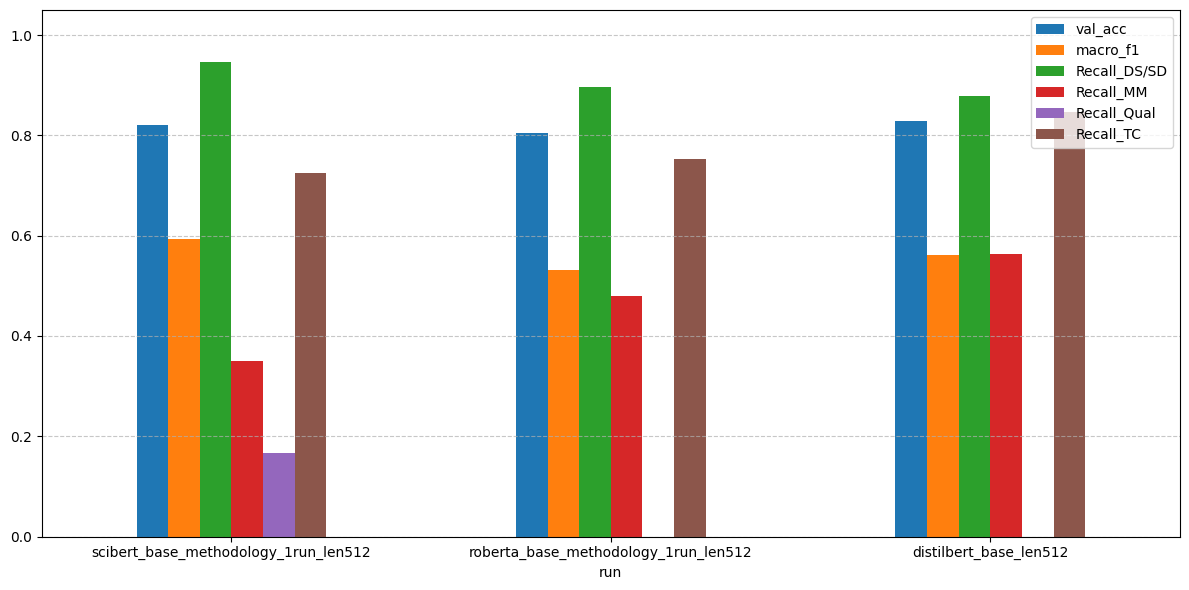

In [ ]:
from google.colab import files
# Upload one or more files
up = files.upload()

# Read → keep only TF-IDF metric set → stack
dfs = []
for name, data in up.items():
    if name.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(io.BytesIO(data))
    else:
        df = pd.read_csv(io.BytesIO(data))
    keep = [c for c in df.columns
            if c == "run" or c in ("val_acc", "macro_f1") or c.lower().startswith("recall_")]
    dfs.append(df[keep])

combined = pd.concat(dfs, ignore_index=True)
combined = combined[
    ["run"]
    + [c for c in ("val_acc", "macro_f1") if c in combined.columns]
    + [c for c in combined.columns if c.lower().startswith("recall_")]
]

# Rename recall columns for display
combined = combined.rename(columns={
    "recall_Design_Science_/_System_Design": "Recall_DS/SD",
    "recall_Mixed_Methods": "Recall_MM",
    "recall_Qualitative": "Recall_Qual",
    "recall_Theoretical_/_Conceptual": "Recall_TC",
})

# Round + show
num_cols = combined.select_dtypes("number").columns
combined[num_cols] = combined[num_cols].round(6)
display(combined)

# Plot
metrics = [c for c in ["val_acc","macro_f1","Recall_DS/SD","Recall_MM","Recall_Qual","Recall_TC"] if c in combined.columns]
combined.set_index("run")[metrics].plot(kind="bar", figsize=(12,6), rot=0)
plt.ylim(0, 1.05); plt.grid(axis="y", linestyle="--", alpha=0.7); plt.tight_layout(); plt.show()

## 5.3 All Models (Macro F1)

The macro-F1 ranking across all baselines and extensions shows a stable pattern: SciBERT Model 1 delivers the highest balanced performance without relying on aggressive training heuristics. This is not an artefact of one split or token length. The token-length study established that 256 tokens cover almost all abstracts, and across both 512 and 256 contexts the ordering remains consistent. Where extensions help (e.g., RoBERTa with loss weights), gains are incremental and confined to specific families; they do not overturn the ranking.

The most plausible explanation is representational: SciBERT’s pretraining on scientific corpora confers an inductive bias that aligns with methodological language (e.g., study design, theoretical framing, evidential stance) that is distributed across sentences rather than concentrated in keywords. DistilBERT attains strong accuracy through confident decisions on the frequent labels, but macro-F1 reveals a gap on minority classes. RoBERTa is competitive yet typically requires weighting or sampling to approach the same balance.

Conclusion. For a classifier where balanced coverage is the objective metric, I select SciBERT Model 1 as the reference model. It achieves the highest macro-F1, preserves high recall on the easy classes, and critically does so without fragile, run-specific tuning. This makes it the most defensible backbone to carry forward into downstream analyses and the multi-label pipeline.

Saving all_extended_models.xlsx to all_extended_models (2).xlsx
Saving all_model1.xlsx to all_model1 (3).xlsx


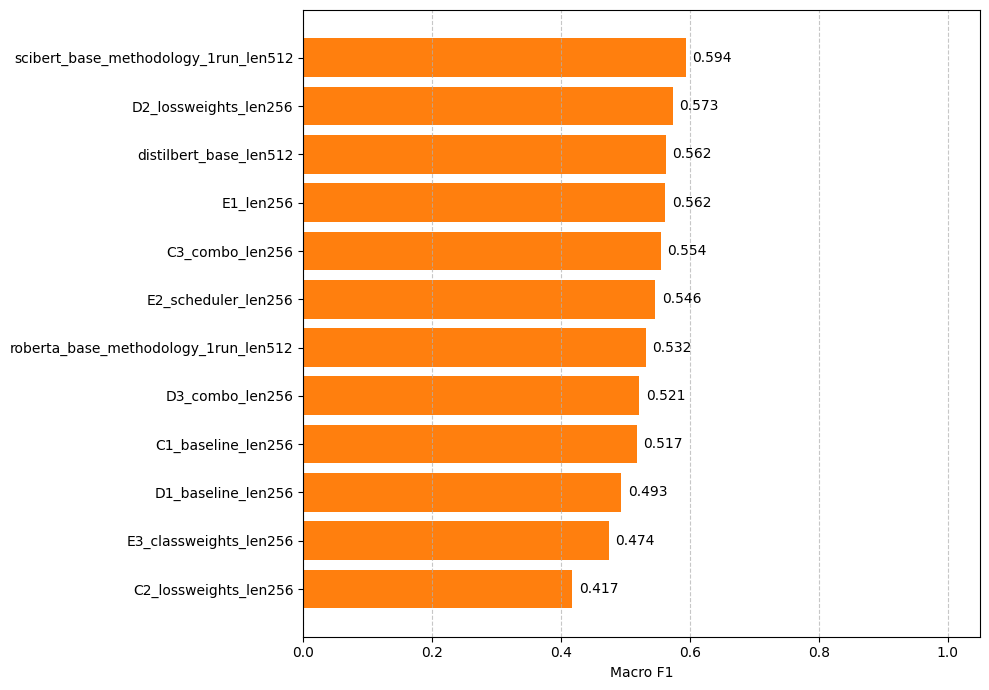

In [ ]:
from google.colab import files
# Upload one or more files
up = files.upload()

# Read ALL columns and combine
dfs_full = []
for name, data in up.items():
    if name.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(io.BytesIO(data))
    else:
        df = pd.read_csv(io.BytesIO(data))
    dfs_full.append(df)

full_df = pd.concat(dfs_full, ignore_index=True)

# Macro-F1 bar chart
plot_df = full_df[["run", "macro_f1"]].dropna().copy()
plot_df["macro_f1"] = plot_df["macro_f1"].astype(float).round(6)
plot_df = plot_df.sort_values("macro_f1", ascending=False)

fig, ax = plt.subplots(figsize=(10, max(3, 0.5 * len(plot_df) + 1)))
ax.barh(plot_df["run"], plot_df["macro_f1"], color="tab:orange")
ax.set_xlabel("Macro F1"); ax.set_ylabel(""); ax.set_xlim(0, 1.05)
ax.grid(axis="x", linestyle="--", alpha=0.7)
for i, v in enumerate(plot_df["macro_f1"]):
    ax.text(v + 0.01, i, f"{v:.3f}", va="center")
ax.invert_yaxis()
plt.tight_layout(); plt.show()

## 5.4 All Models (Per Class Recall)

The per-class recall heatmap explains the macro-F1 ordering by locating where each model derives (or loses) performance. Design Science/System Design and Theoretical/Conceptual are consistently high across families, indicating abundant, separable signal. The differentiation appears in Mixed Methods and, most notably, Qualitative. Reweighting improves Mixed Methods in models such as RoBERTa-D2, but Qualitative remains difficult: most backbones fail to register it at all, whereas SciBERT is the only family that reproducibly yields non-zero recall on this split.

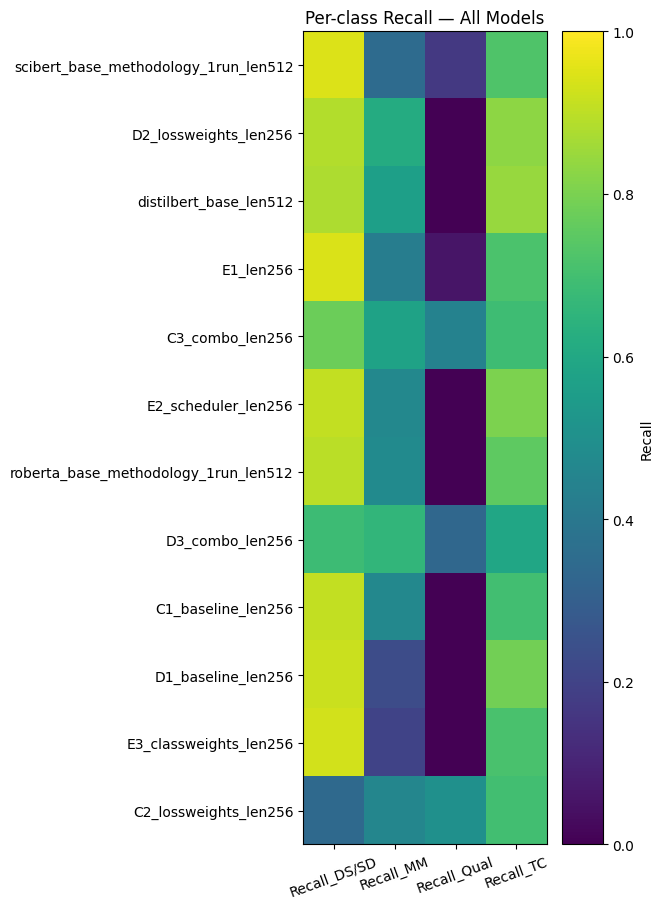

In [ ]:
rename_map = {
    "recall_Design_Science_-_System_Design": "Recall_DS/SD",
    "recall_Mixed_Methods": "Recall_MM",
    "recall_Qualitative": "Recall_Qual",
    "recall_Theoretical_-_Conceptual": "Recall_TC",
}
heat_df = full_df.rename(columns=rename_map)

# Build matrix
recall_cols = ["Recall_DS/SD", "Recall_MM", "Recall_Qual", "Recall_TC"]
missing = [c for c in recall_cols if c not in heat_df.columns]
if missing:
    raise ValueError(f"Missing recall columns: {missing}")

# align row order with Macro-F1 chart
if 'plot_df' in globals():
    heat_df = heat_df.set_index("run").loc[plot_df["run"]].reset_index()

mat = heat_df[recall_cols].astype(float).to_numpy()
row_labels = heat_df["run"].astype(str).tolist()

plt.figure(figsize=(6.4, 0.6 * len(row_labels) + 2))
plt.imshow(mat, aspect="auto", vmin=0, vmax=1)
plt.xticks(range(len(recall_cols)), recall_cols, rotation=20)
plt.yticks(range(len(row_labels)), row_labels)
plt.colorbar(label="Recall")
plt.title("Per-class Recall — All Models")
plt.tight_layout(); plt.show()

# 6. Multi Label Classification (SciBERT)

I extend the task from single-label (one target per sample) to multi-label: each abstract can carry a discipline, a subfield, and a methodology simultaneously. I keep the backbone and data recipe from SciBERT Model 1 to isolate the effect of changing the prediction objective: the model now emits one logit per label and decisions are made independently per label (sigmoid + threshold).

Macro-F1 is the decision metric. On the validation split, macro-F1 lands in the low-to-mid-0.4s across families (methodology at about 0.43; subfield lower; discipline similar), reflecting that minority labels remain hard when each label is predicted independently. On the validation split the element-wise accuracy is about 0.89. Slicing the reports by family shows a familiar pattern: discipline and subfield are learned reliably (several labels in the 0.6–0.8 recall range), while methodology remains the hardest DS/SD high, TC moderate, MM low, and Qualitative near zero on this split. That continuity with the single-label experiments matters: moving to multi-label preserves strengths but does not magically fix the weakest class, so any further gains will need targeted rebalancing or data.



### Configuration

In [ ]:
#  Config and Seed
@dataclass
class RunConfig:
    model_name: str = "allenai/scibert_scivocab_uncased"
    max_len: int = 512
    batch_size: int = 4
    lr: float = 2e-5
    weight_decay: float = 0.0
    epochs: int = 10
    patience: int = 2
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = RunConfig()

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

### Tokenisation

The task is made multi-label by building a multi-hot target over {discipline, subfield, methodology} using MultiLabelBinarizer; I persist the encoder to mlb.pkl and the class list to classes.npy for later decoding. Texts come from processed_with_stopwords and are tokenized by the SciBERT tokenizer at max_len=512. I use an 80/20 split with seed=42 and wrap encodings plus targets into a small Dataset, producing train/val DataLoaders (training shuffled).

In [ ]:
def label_list(row):
    return [row['discipline'], row['subfield'], row['methodology']]

df['labels'] = df.apply(label_list, axis=1)

mlb = MultiLabelBinarizer()
all_labels = mlb.fit_transform(df['labels'])
classes = np.array(mlb.classes_)

with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)

np.save("classes.npy", classes)

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=cfg.max_len)

tokens = tokenize_function(df['processed_with_stopwords'].tolist())

class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

# Train/val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_with_stopwords'].tolist(),
    all_labels, test_size=0.2, random_state=42
)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = MultiLabelDataset(train_encodings, train_labels)
val_dataset = MultiLabelDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

### Runner

MultiLabelSciBERT feeds the sequence through SciBERT, takes the CLS vector, applies dropout, and projects to one logit per label. Optimisation uses BCEWithLogitsLoss (independent binary decisions), AdamW(2e-5), a short LinearLR warm-up (of about 10% of steps), and gradient clipping at 1.0; early stopping monitors validation loss. At inference I apply a 0.5 sigmoid threshold per label. I report element-wise accuracy across the label matrix and classification_reports grouped by family (Discipline, Subfield, Methodology).

In [ ]:
class MultiLabelSciBERT(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(cfg.model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

model = MultiLabelSciBERT(num_labels=all_labels.shape[1]).to(cfg.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
criterion = nn.BCEWithLogitsLoss()

total_steps = len(train_loader) * cfg.epochs
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=int(0.1 * total_steps))  # warmup 10%

best_val_loss = float("inf")
patience_counter = 0
best_state_dict = None

for epoch in range(1, cfg.epochs + 1):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(cfg.device)
        attention_mask = batch['attention_mask'].to(cfg.device)
        labels = batch['labels'].to(cfg.device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(cfg.device)
            attention_mask = batch['attention_mask'].to(cfg.device)
            labels = batch['labels'].to(cfg.device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            targets = labels.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)

    avg_val_loss = val_loss / len(val_loader)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    val_acc = (all_preds == all_targets).mean()

    print(f"Epoch {epoch:02d} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f} | patience {patience_counter}/{cfg.patience}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        patience_counter = 0
        torch.save(best_state_dict, "multi_label_scibert.pt")
    else:
        patience_counter += 1
        if patience_counter >= cfg.patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state_dict)
model.eval()
final_preds, final_targets = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(cfg.device)
        attention_mask = batch['attention_mask'].to(cfg.device)
        labels = batch['labels'].to(cfg.device)

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5

        final_preds.append(preds)
        final_targets.append(labels.cpu().numpy())

final_preds = np.vstack(final_preds)
final_targets = np.vstack(final_targets)
print("\nValidation accuracy:", (final_preds == final_targets).mean())

def group_report(label, group_list):
    indices = [i for i, c in enumerate(classes) if c in group_list]
    if indices:
        print(f"\nClassification Report — {label}")
        print(classification_report(
            final_targets[:, indices], final_preds[:, indices], target_names=classes[indices], zero_division=0
        ))

group_report("Discipline", df['discipline'].unique().tolist())
group_report("Subfield", df['subfield'].unique().tolist())
group_report("Methodology", df['methodology'].unique().tolist())

Epoch 01 | train_loss: 0.3189 | val_loss: 0.2670 | val_acc: 0.8905 | patience 0/2
Epoch 02 | train_loss: 0.2610 | val_loss: 0.2511 | val_acc: 0.8933 | patience 0/2
Epoch 03 | train_loss: 0.2332 | val_loss: 0.2481 | val_acc: 0.8965 | patience 0/2
Epoch 04 | train_loss: 0.2054 | val_loss: 0.2599 | val_acc: 0.8940 | patience 0/2
Epoch 05 | train_loss: 0.1720 | val_loss: 0.2778 | val_acc: 0.8927 | patience 1/2
Early stopping triggered.

Validation accuracy: 0.8927036705461057

Classification Report — Discipline
                                            precision    recall  f1-score   support

                              Astrophysics       0.71      0.80      0.76        46
                          Computer Science       0.50      0.22      0.30       268
                                 Economics       0.64      0.90      0.75       245
Electrical Engineering and Systems Science       0.33      0.07      0.11        29
                               Mathematics       0.49      0.34   

# 7. Complete Working Classification Pipeline

### Loading Assets

This cell ingests the three artifacts produced during training, mlb.pkl (the fitted MultiLabelBinarizer), classes.npy (the frozen label order), and multi_label_scibert.pt (the fine-tuned weights). Writing the raw bytes to disk and normalising names guarantees the inference code sees exactly the filenames it expects. Keeping the class order identical to training is critical: it ensures each logit maps to the same semantic label at inference as it did during training, so per-family selection and confidence reporting remain correct.

In [ ]:
# Upload and standardise filenames
from google.colab import files


# Upload files
print("Please select: mlb.pkl, classes.npy, multi_label_scibert.pt")
up = files.upload()
if not up:
    raise RuntimeError("No files uploaded.")

# Save uploaded bytes
for name, data in up.items():
    with open(name, "wb") as f:
        f.write(data)

def ensure_file(target_name, exts):
    """If target_name not present, rename first uploaded file matching extensions."""
    if os.path.exists(target_name):
        return target_name
    for fname in up.keys():
        if any(fname.lower().endswith(ext) for ext in exts):
            if fname != target_name:
                os.rename(fname, target_name)
            return target_name
    raise FileNotFoundError(f"Missing {target_name}. Upload a file with extension(s) {exts}.")

ensure_file("mlb.pkl", [".pkl"])
ensure_file("classes.npy", [".npy"])
ensure_file("multi_label_scibert.pt", [".pt"])

Please select: mlb.pkl, classes.npy, multi_label_scibert.pt


Saving classes.npy to classes.npy
Saving mlb.pkl to mlb.pkl
Saving multi_label_scibert.pt to multi_label_scibert.pt


'multi_label_scibert.pt'

### Define Model

The model wraps allenai/scibert_scivocab_uncased with a light classification head and pools the [CLS] token. The forward pass accepts token_type_ids for compatibility, though SciBERT won’t use them; leaving the signature flexible avoids tokenizer/model mismatch errors. After loading the saved state dict and moving to eval() on CPU/GPU, the cell defines a pragmatic PDF abstract extractor: scan the first pages, look for an “Abstract” header, and fall back to the first ~1.5k characters. This keeps latency low and aligns the inference text with what the model saw during training (abstract-length inputs).

In [ ]:
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model definition & load
class MultiLabelSciBERT(torch.nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,
        token_type_ids=token_type_ids)
        pooled = outputs.last_hidden_state[:, 0]              # [CLS]-like token
        return self.classifier(self.dropout(pooled))

# Load encoder, class names, tokeniser, and model weights
with open("mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

classes = np.load("classes.npy", allow_pickle=True)
classes = list(classes)  # ensure python list

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

model = MultiLabelSciBERT(num_labels=len(classes))
model.load_state_dict(torch.load("multi_label_scibert.pt", map_location="cpu"))
model.to(device).eval()

# PDF Extraction
def extract_abstract_from_pdf(pdf_path, pages_to_scan=2, fallback_chars=1500):
    """Find text after an 'Abstract' header; fall back to first N chars of first pages."""
    text_blocks = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages[:pages_to_scan]:
            t = page.extract_text() or ""
            text_blocks.append(t)
    full_text = "\n".join(text_blocks)

    # Normalise hyphenation & spaces a bit
    full_text = re.sub(r"-\n", "", full_text)
    full_text = re.sub(r"\s+\n", "\n", full_text)

    lines = full_text.splitlines()
    abstract = ""
    for i, line in enumerate(lines):
        if re.search(r"\babstract\b", line, flags=re.IGNORECASE):
            # Take the next few lines as the abstract body
            abstract = " ".join(lines[i+1:i+12])
            break

    if not abstract:
        abstract = full_text[:fallback_chars]
    return abstract.strip()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 58.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

### Runner

predict_labels tokenises a string, applies the model, and turns logits into probabilities via sigmoid, thresholded at 0.5. The helper get_label_groups() declares the three families (discipline, subfield, methodology) using the saved classes. group_predictions converts multi-label outputs into a single, human-readable tag per family by taking the highest-probability label within each group (while still returning the full on/off vector). Finally, print_grouped_confidences lists each family sorted by probability and marks which labels crossed the threshold useful for quick sanity checks and for spotting borderline cases without opening extra plots.

In [ ]:
# Inference
def predict_labels(text, max_len=256, threshold=0.5):
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc)
        probs = torch.sigmoid(logits).squeeze().detach().cpu().numpy()
    preds = (probs > threshold).astype(int)
    return preds, probs

# Label group helpers
def get_label_groups():
    """Return lists of labels for Discipline, Methodology, and Subfield."""
    disc_list = [
        'Computer Science', 'Mathematics', 'Physics', 'Economics',
        'Quantitative Biology', 'Statistics',
        'Electrical Engineering and Systems Science', 'Astrophysics'
    ]
    meth_list = [
        'Qualitative', 'Mixed Methods',
        'Theoretical / Conceptual', 'Design Science / System Design'
    ]
    sub_list = [lbl for lbl in classes if lbl not in disc_list + meth_list]
    return disc_list, meth_list, sub_list

# Grouped prediction selector
def group_predictions(preds, probs):
    """
    Returns:
      discipline (str|None), subfield (str|None), methodology (str|None),
      pred_labels (list[str]), probs (np.ndarray)
    """
    disc_list, meth_list, sub_list = get_label_groups()

    def best_of(group):
        idxs = [i for i, c in enumerate(classes) if c in group]
        if not idxs:
            return None
        return classes[max(idxs, key=lambda i: probs[i])]

    discipline  = best_of(disc_list)
    subfield    = best_of(sub_list)
    methodology = best_of(meth_list)
    pred_labels = [classes[i] for i, v in enumerate(preds) if v == 1]

    return discipline, subfield, methodology, pred_labels, probs

# Pretty-print grouped confidences
def print_grouped_confidences(probs, preds):
    disc_list, meth_list, sub_list = get_label_groups()
    width = max(len(lbl) for lbl in classes) + 2
    prob_map = {lbl: float(probs[i]) for i, lbl in enumerate(classes)}
    on_labels = {classes[i] for i, v in enumerate(preds) if v == 1}

    def dump(title, labels):
        rows = [(lbl, prob_map.get(lbl, 0.0)) for lbl in labels]
        rows.sort(key=lambda x: x[1], reverse=True)
        print(f"{title}:")
        for lbl, p in rows:
            star = " *" if lbl in on_labels else ""
            print(f"  {lbl:{width}}: {p:.2f}{star}")
        print()

    dump("Discipline",  disc_list)
    dump("Subfield",    sub_list)
    dump("Methodology", meth_list)

### Batch Inference Product

This cell provides the end-to-end loop: upload one or more PDFs, extract an abstract-length snippet, run the model, and display (i) the top discipline, subfield, and methodology and (ii) the ordered confidence tables for each family. Exceptions are caught per file so a bad scan or malformed PDF won’t interrupt the whole batch. The result is a self-contained demo: drop in papers, get structured tags plus transparent scores.

In [ ]:
# Upload & Predict Multiple PDFs
uploaded = files.upload()

for filename in uploaded:
    print(f"\nFile: {filename}")
    try:
        text = extract_abstract_from_pdf(filename)
        if not text.strip():
            print("No extractable text found in the first pages; skipping.\n")
            continue

        print(f"\nExtracted Abstract (preview):\n{text[:500]}...\n")

        preds, probs = predict_labels(text)
        discipline, subfield, methodology, pred_labels, probs = group_predictions(preds, probs)

        print("Predicted Categories:")
        print(f"  Discipline : {discipline}")
        print(f"  Subfield   : {subfield}")
        print(f"  Methodology: {methodology}\n")

        print("Confidence per label (grouped):")
        print_grouped_confidences(probs, preds)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

Saving 2506.09330v1.pdf to 2506.09330v1.pdf
Saving 2506.14102v1.pdf to 2506.14102v1.pdf
Saving 2508.02508v1.pdf to 2508.02508v1.pdf
Saving 2508.02548v1.pdf to 2508.02548v1.pdf
Saving 0503311v1.pdf to 0503311v1.pdf

File: 2506.09330v1.pdf

Extracted Abstract (preview):
We design a portfolio construction framework and implement an active investment strategy utilizing momentum and trend-following signals across multiple asset classes and asset class risk factors. We quantify the performance of this strategy to demonstrate its ability to create excess returns above industry standard benchmarks, as well as manage volatility and drawdown risks over a 22+ year period. 1. Introduction Conscious Capital Advisors is an investment advisory firm that combines rigorous re...

Predicted Categories:
  Discipline : Economics
  Subfield   : General Economics
  Methodology: Design Science / System Design

Confidence per label (grouped):
Discipline:
  Economics                                   : 0.77 *


# 8. Conclusion and Discussion

So all in all, this project documents an end-to-end build of a research-paper classifier: data prep, TF-IDF baselines, three transformer families, targeted extensions, a multi-label SciBERT, and a runnable PDF-to-labels pipeline. The decision rule for “best model” was grounded in macro-F1 (equal weight per class) with per-class recall as a secondary lens for methodology—where minority coverage matters. Under that criterion, SciBERT Model 1 emerged as the most balanced backbone; its multi-label variant preserved that balance across discipline, subfield, and methodology.

The engineering has showed that:

- Pretraining priors matter. SciBERT’s scientific domain pretraining helped recover non-keyword cues (e.g., discourse markers) and gave the best macro-F1 on methodology. RoBERTa was broadly strong but needed rebalancing to lift the smallest class. DistilBERT was efficient and accurate on dominant labels but under-fitted the smallest class without targeted biasing.

- A token-length study justified 256 as a safe operating point for most abstracts (used in extended runs), while 512 was kept for the headline Model-1 baselines to avoid truncation confounds in the first comparison.

- Multi-label training required BCEWithLogitsLoss, per-label thresholding, and custom early-stopping logic; implementing these directly was more stable in Colab and simpler to debug than bending a generic Trainer around them.

- Hyperparameter tuning was model-specific by design and necessity. RoBERTa benefited from warm-up/label smoothing/loss weights; DistilBERT was more sensitive to warm-up; SciBERT was already stable with minimal tweaks. Colab GPU/memory limits also constrained exhaustive sweeps. Read the cross-model gaps as reasonable, model-appropriate tuning, not fully saturated optima. Key controls (split, tokenisation, selection rule) were held fixed to anchor fairness.

Constraints encountered (and how they shaped my choices):

- GPU/time limits influenced batch sizes, epoch counts, and the choice to prefer early stopping over long schedules or large HPO grids.

- Label growth during data collection created a moving target: adding papers surfaced new subfields/methods. A practical “scope freeze” was applied to keep the label space stable for training and evaluation, with ontology clean-ups deferred to future work.

- Explainability at scale (LIME) was memory-fragile in Colab; it was run locally to extract qualitative insights and to design a simple rule-based fallback for very low-confidence cases.